### todos

**general todos**  
[ ] eventually fix the paths for anyone not running this from src directory (remove ...)

[x] map setup numbers to better names for all plots

[ ] traverse setup folders and concat dfs

[ ] do some significance tests based on results_df

[ ] combine ALL the run results and do a regression with a lot more parameters!

**Plots I want this to work on**  
[ ] Time plot?

[x] Fitness_plot

    [ ] comparing best vs. avg vs best species (needs to be only done once)

[x] Total components?

[x] Unique components per generation

[x] Mutation boxplot effects

[x] fitness Metrics plots

[ ] best genome mutation analysis

[x] Mutation lineplots

[x] Average metrics?

[ ] Number species

[x] Spawn rank histogram

[x] Scatterplot

**Do not forget about single-run plots, they should also be in here**  
[ ] best genome lineage

[ ] species leaders??

[ ] species stackplot

[ ] species tree

[ ] species ridgeline

[ ] species average fitnesses

[ ] fitness scatterplot (as implemented in look_at_dfs) - can only do that for one run

**Other analysis implemented someplace else**  
[ ] ... check the onenote

**Interesting one-off analysis**  
[ ] Mutation lineage for a selected run

[ ] Component similarity drift

[ ] Fitness of components plotting

    - Look at the components in the fittest genome at the end, plot their t-values obtained from the component dict over the generations

**Those can only be copied from a run**  
[ ] improvements (combine them into something)

[ ] species leaders??

# Analysis of results
In this notebook, I will track all the plots used in the Thesis.

The first step will be evaluating individual selection strategies, with the goal of determining appropriate parameter settings for each selection strategy before comparing the selection strategies agains one another.

For those initial comparisons, I will be sticking to the `running_example.xes` log, but bigger logs will be compared.

## Selection strategy - truncation
First off, analyzing the truncation selection strategy

The Data is from a run with the following parameter permutations
* `spawn_cutoff`: 0.1, 0.25, 0.5, 0.75
* `pop_perc_elite`: 0.01, 0.05
* `pop_perc_crossover`: 0.0, 0.1, 0.2, 0.3, 0.4

### Regression on truncation parameters
Probably the most influental parameter, it should directly expose the trade-offs of diversity vs. focus during the search. I.e. trading faster convergence for a narrower search. `spawn_cutoff` determines which portion of the population will be moved into the next.

For every parameter change, all the other parameter changes are also tested, resulting in a total of `4*2*5 = 40` setups. That also means that The spawn cutoff was tested with all `pop_perc_elite` and `pop_perc_crossover` settings. Each setup was run 20 times.

I did not run a test with 0% elitism. Usually elitism is crucial to ensuring that the best mutations cannot possibly get lost in the unlikely event of not being selected for the next generation. This event cannot occur in truncation selection, as the selection function simply iterates the population in descending order to spawn offspring. However - elitism is definitely crucial for speciation selection; and while extremely unlikely - roulette selection could also in theory loose the best genome in one generation by not selecting it as a parent. To ensure that I can easily compare my results and reduce the number of possible setups, I did not test truncation without elitism.

To investigate the hypothesis that spawn cutoff has the largest effect on achieved diversity, I rely on the num_components metric which was calculated for every run, as well as the highest achieved fitness and do a regression for both of those target variables. Predictors are the params that were changed, i.e. spawn cutoff, % elite spawns and % crossover spawns.

In [1]:
from importlib import reload # TODO: remove this later
import scripts.helper_scripts.setup_analysis as sa # helper module for fetching setup analysis
# crawl the results data and load it into a dict
res = sa.exec_results_crawler("../analysis/data/truncation_test")

Processing setup directories: 43it [00:00, 2389.41it/s]


Found cached results for setup_1
Successfully loaded cached results for setup_1

Found cached results for setup_10
Successfully loaded cached results for setup_10

Found cached results for setup_11
Successfully loaded cached results for setup_11

Found cached results for setup_12
Successfully loaded cached results for setup_12

Found cached results for setup_13
Successfully loaded cached results for setup_13

Found cached results for setup_14
Successfully loaded cached results for setup_14

Found cached results for setup_15
Successfully loaded cached results for setup_15

Found cached results for setup_16
Successfully loaded cached results for setup_16

Found cached results for setup_17
Successfully loaded cached results for setup_17

Found cached results for setup_18
Successfully loaded cached results for setup_18

Found cached results for setup_19
Successfully loaded cached results for setup_19

Found cached results for setup_2
Successfully loaded cached results for setup_2

Found c

In [2]:
regression_result = sa.run_regression(res, ["spawn_cutoff", "pop_perc_elite", "pop_perc_crossover"]);


Regression Results for num_components
--------------------------------------------------
R-squared: 0.8626
Adjusted R-squared: 0.8621

Standardized Coefficients:
spawn_cutoff           949.3926 (p=0.0000)
pop_perc_elite        -106.7737 (p=0.0000)
pop_perc_crossover    -432.3445 (p=0.0000)

Regression Results for max_fitness
--------------------------------------------------
R-squared: 0.0110
Adjusted R-squared: 0.0073

Standardized Coefficients:
spawn_cutoff             0.0073 (p=0.0139)
pop_perc_elite          -0.0040 (p=0.1755)
pop_perc_crossover       0.0029 (p=0.3354)


Turns out that 86% of the variance in num_components can be explained by the selected parameters. All three predictors have significant effects on the number of components, with the largest effect being the positive effect of increasing the cutoff. Increasing the number of elite spawns, which are simply cloning the best genome without mutations (with the goal to increase the fraction of elite genomes in the spawnpool so they will mutate in the next generation) leads as expected to a decrease in diversity.
Crossover also has a pretty strong negative effect on the number of components discovered, which does make sense, because crossover effectively replaces one component in one genome with that of another genome, thus reducing the total number of unique components in the genepool. Furthermore, crossover genomes do not undergo any mutations.

On the other hand, the effects of the tested parameters are pretty minimal on the achieved maximum fitness, with none being significant. This is because for this small log there is almost no correlation between diversity and max fitness achieved - as will be seen later in **TODO**: DO A SCATTER OF ALL THE RUNS AND CALC COMPONENT ~ FITNESS CORR. + test log size increases maybe change in the relation of diversity x fitness

When it comes to the highest achievable fitness, there are bigger knobs to turn - other selection strategies, mutation rates and of course the fitness function itself.



### Interaction cutoff ~ elitism on absolute fitness and number of components at the end of run
The barcharts below plot the average max fitness of each run, along with the avg. num of components that were discovered, when filtering for runs with both elitism and all 4 cutoff settings. The different crossover settings that were used for each of those parameter configurations are averaged out, i.e. each one of those bars includes data from all 5 crossover settings.

An error occurred: unable to append to a DataFrame of width 44 with a DataFrame of width 47
this was most likely because there are missing columns in one of the dataframes, will use diagonal join
An error occurred: unable to append to a DataFrame of width 47 with a DataFrame of width 44
this was most likely because there are missing columns in one of the dataframes, will use diagonal join
An error occurred: unable to append to a DataFrame of width 44 with a DataFrame of width 47
this was most likely because there are missing columns in one of the dataframes, will use diagonal join
An error occurred: unable to append to a DataFrame of width 44 with a DataFrame of width 47
this was most likely because there are missing columns in one of the dataframes, will use diagonal join
An error occurred: unable to append to a DataFrame of width 44 with a DataFrame of width 47
this was most likely because there are missing columns in one of the dataframes, will use diagonal join
An error occurred: u

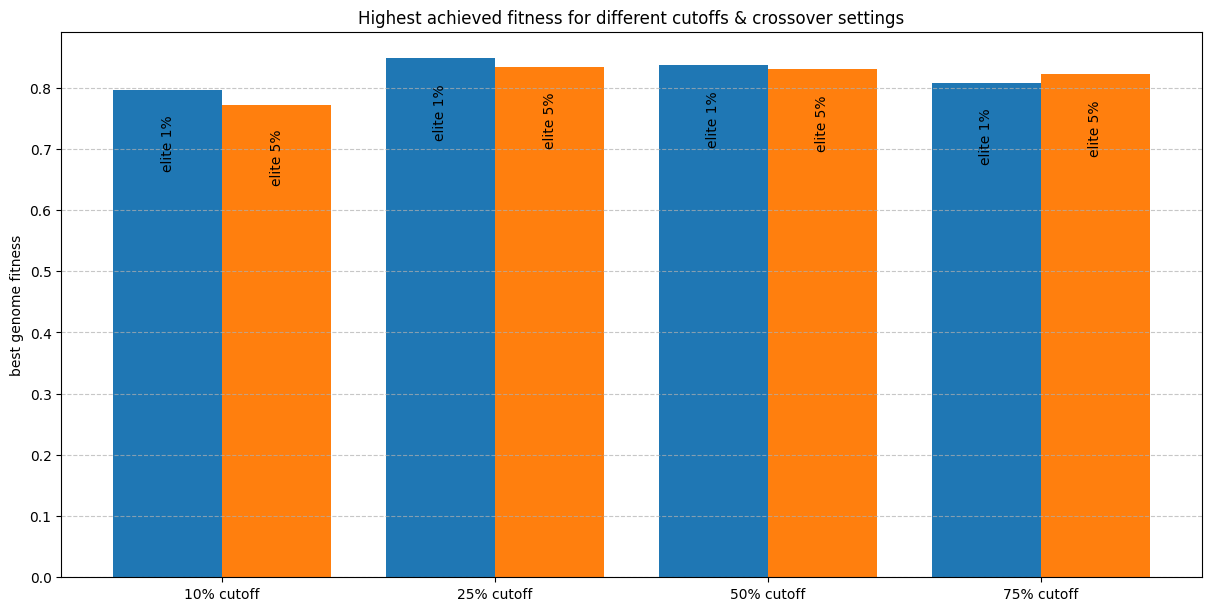

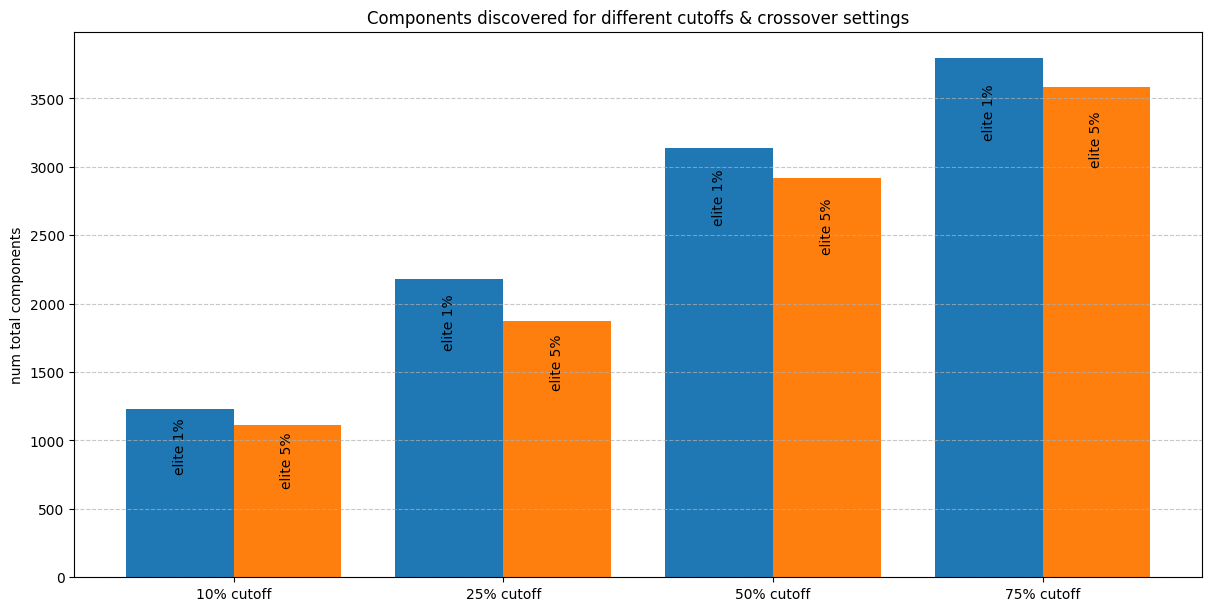

In [3]:
reload(sa)
# TODO: update text above

cutoff_elite_search = {
    "cutoff 10% & elite 1%": {"spawn_cutoff": 0.1, "pop_perc_elite":  0.01}, "cutoff 10% & elite 5%": {"spawn_cutoff": 0.1, "pop_perc_elite":  0.05},
    "cutoff 25% & elite 1%": {"spawn_cutoff": 0.25, "pop_perc_elite": 0.01}, "cutoff 25% & elite 5%": {"spawn_cutoff": 0.25, "pop_perc_elite": 0.05},
    "cutoff 50% & elite 1%": {"spawn_cutoff": 0.50, "pop_perc_elite": 0.01}, "cutoff 50% & elite 5%": {"spawn_cutoff": 0.50, "pop_perc_elite": 0.05},
    "cutoff 75% & elite 1%": {"spawn_cutoff": 0.75, "pop_perc_elite": 0.01}, "cutoff 75% & elite 5%": {"spawn_cutoff": 0.75, "pop_perc_elite": 0.05}
}


elite_plt_layout = [
    ["cutoff 10% & elite 1%", "cutoff 10% & elite 5%"],
    ["cutoff 25% & elite 1%", "cutoff 25% & elite 5%"],
    ["cutoff 50% & elite 1%", "cutoff 50% & elite 5%"],
    ["cutoff 75% & elite 1%", "cutoff 75% & elite 5%"]
]

elite_data_sources = sa.search_and_aggregate_param_results(res, cutoff_elite_search)
strip_first_param = lambda l: l.split('&')[1].strip().split('\n')[0] # lambda to be applied on labels
_ = sa.generalized_barplot(elite_plt_layout, elite_data_sources, "best_genome_fitness", title="Highest achieved fitness for different cutoffs & crossover settings", group_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"], label_lambda=strip_first_param)
_ = sa.generalized_barplot(elite_plt_layout, elite_data_sources, "num_total_components", title="Components discovered for different cutoffs & crossover settings", group_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"], label_lambda=strip_first_param)

This again shows how none of the settings really have an impact on the achieved mean fitness. At the end, I will compare all setups, i.e. all parameter permutations to identify the best settings within my sample and compare that to the analysis here. However elitism clearly exhibits a negative effect on the total number of components. At really high cutoffs of 75%, elitism ensures that the proportion of good genomes is higher in the gene pool, resulting to a slight boost in fitness compared to a 1% elitism rate. Overall - when aggregating the different crossover settings and looking just at elitism and crossover, the first barchart indicates that a cutoff rate of about 25% is beneficial for fitness when using the current small log, as the search becomes more focused.

### Interaction cutoff ~ crossover on absolute fitness and number of components at the end of run
I will now do the same visualization, this time filtering by cutoff and crossover rate, and both elitism settings will be averaged out.

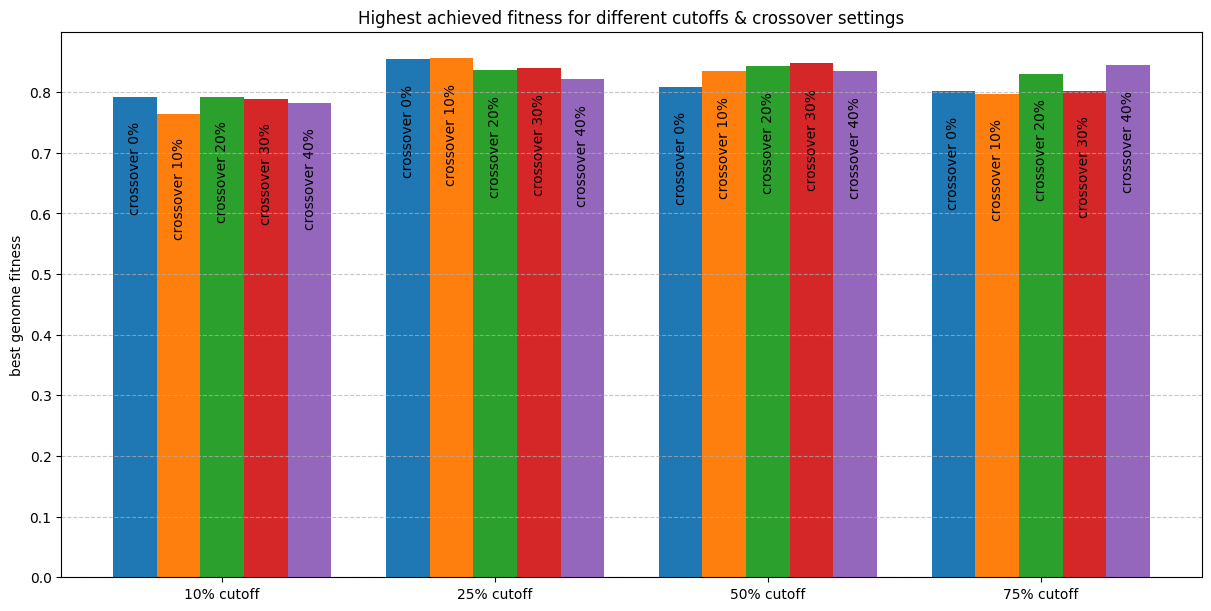

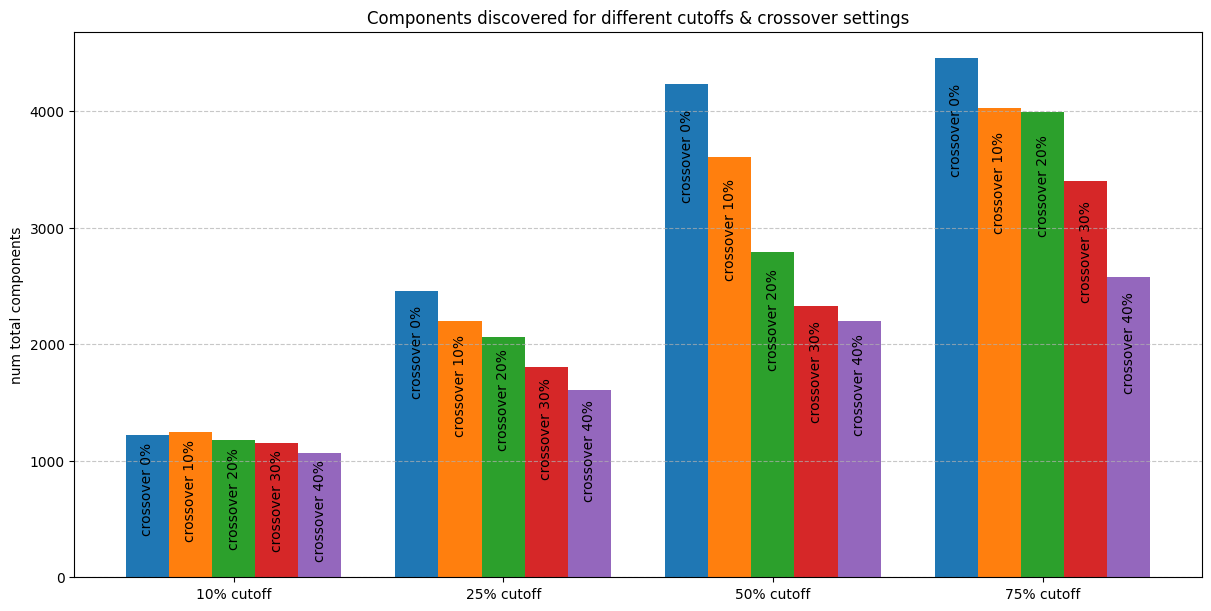

In [4]:
reload(sa)
cutoff_crossover_search = {
    "cutoff 10% & crossover 0%": {"spawn_cutoff": 0.10, "pop_perc_crossover": 0.0}, "cutoff 10% & crossover 10%": {"spawn_cutoff": 0.10, "pop_perc_crossover": 0.1}, "cutoff 10% & crossover 20%": {"spawn_cutoff": 0.10, "pop_perc_crossover": 0.2}, "cutoff 10% & crossover 30%": {"spawn_cutoff": 0.10, "pop_perc_crossover": 0.3}, "cutoff 10% & crossover 40%": {"spawn_cutoff": 0.10, "pop_perc_crossover": 0.4},
    "cutoff 25% & crossover 0%": {"spawn_cutoff": 0.25, "pop_perc_crossover": 0.0}, "cutoff 25% & crossover 10%": {"spawn_cutoff": 0.25, "pop_perc_crossover": 0.1}, "cutoff 25% & crossover 20%": {"spawn_cutoff": 0.25, "pop_perc_crossover": 0.2}, "cutoff 25% & crossover 30%": {"spawn_cutoff": 0.25, "pop_perc_crossover": 0.3}, "cutoff 25% & crossover 40%": {"spawn_cutoff": 0.25, "pop_perc_crossover": 0.4},
    "cutoff 50% & crossover 0%": {"spawn_cutoff": 0.50, "pop_perc_crossover": 0.0}, "cutoff 50% & crossover 10%": {"spawn_cutoff": 0.50, "pop_perc_crossover": 0.1}, "cutoff 50% & crossover 20%": {"spawn_cutoff": 0.50, "pop_perc_crossover": 0.2}, "cutoff 50% & crossover 30%": {"spawn_cutoff": 0.50, "pop_perc_crossover": 0.3}, "cutoff 50% & crossover 40%": {"spawn_cutoff": 0.50, "pop_perc_crossover": 0.4},
    "cutoff 75% & crossover 0%": {"spawn_cutoff": 0.75, "pop_perc_crossover": 0.0}, "cutoff 75% & crossover 10%": {"spawn_cutoff": 0.75, "pop_perc_crossover": 0.1}, "cutoff 75% & crossover 20%": {"spawn_cutoff": 0.75, "pop_perc_crossover": 0.2}, "cutoff 75% & crossover 30%": {"spawn_cutoff": 0.75, "pop_perc_crossover": 0.3}, "cutoff 75% & crossover 40%": {"spawn_cutoff": 0.75, "pop_perc_crossover": 0.4},
}

crossover_plt_layout = [
    ["cutoff 10% & crossover 0%", "cutoff 10% & crossover 10%", "cutoff 10% & crossover 20%", "cutoff 10% & crossover 30%", "cutoff 10% & crossover 40%"],
    ["cutoff 25% & crossover 0%", "cutoff 25% & crossover 10%", "cutoff 25% & crossover 20%", "cutoff 25% & crossover 30%", "cutoff 25% & crossover 40%"],
    ["cutoff 50% & crossover 0%", "cutoff 50% & crossover 10%", "cutoff 50% & crossover 20%", "cutoff 50% & crossover 30%", "cutoff 50% & crossover 40%"],
    ["cutoff 75% & crossover 0%", "cutoff 75% & crossover 10%", "cutoff 75% & crossover 20%", "cutoff 75% & crossover 30%", "cutoff 75% & crossover 40%"]
]


crossover_data_sources = sa.search_and_aggregate_param_results(res, cutoff_crossover_search)
strip_first_param = lambda l: l.split('&')[1].strip().split('\n')[0] # lambda to be applied on labels
_ = sa.generalized_barplot(crossover_plt_layout, crossover_data_sources, "best_genome_fitness", title="Highest achieved fitness for different cutoffs & crossover settings", group_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"], label_lambda=strip_first_param)
_ = sa.generalized_barplot(crossover_plt_layout, crossover_data_sources, "num_total_components", title="Components discovered for different cutoffs & crossover settings", group_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"], label_lambda=strip_first_param)

The fitness barcharts indicate a bit of a tradeoff: Generally, a low cutoff of 25% is beneficial, combined with a low crossover rate of 0-10% percent. However there seems to be a second path to high fitness values, which is choosing a high cutoff but then focusing the search by also using a high crossover rate. Since crossover for truncation selection uses a tournament approach for finding 2 mates (current tournament size = 10), there is increased selection from the top genomes. This can also be seen in the spawn rank plots [below](#truncation-spawn-plots). I.e. when using 40% crossover spawns, 40% of the next generation will be selected by a tournament.

### Cutoff ~ Crossover - fitness plot
In the next step, I want to analyze how truncation selection convergences towards it's optimum in the different parameter settings.
First, I will plot the maximum fitness in each generation, averaged across all runs sharing the same cutoff & crossover settings


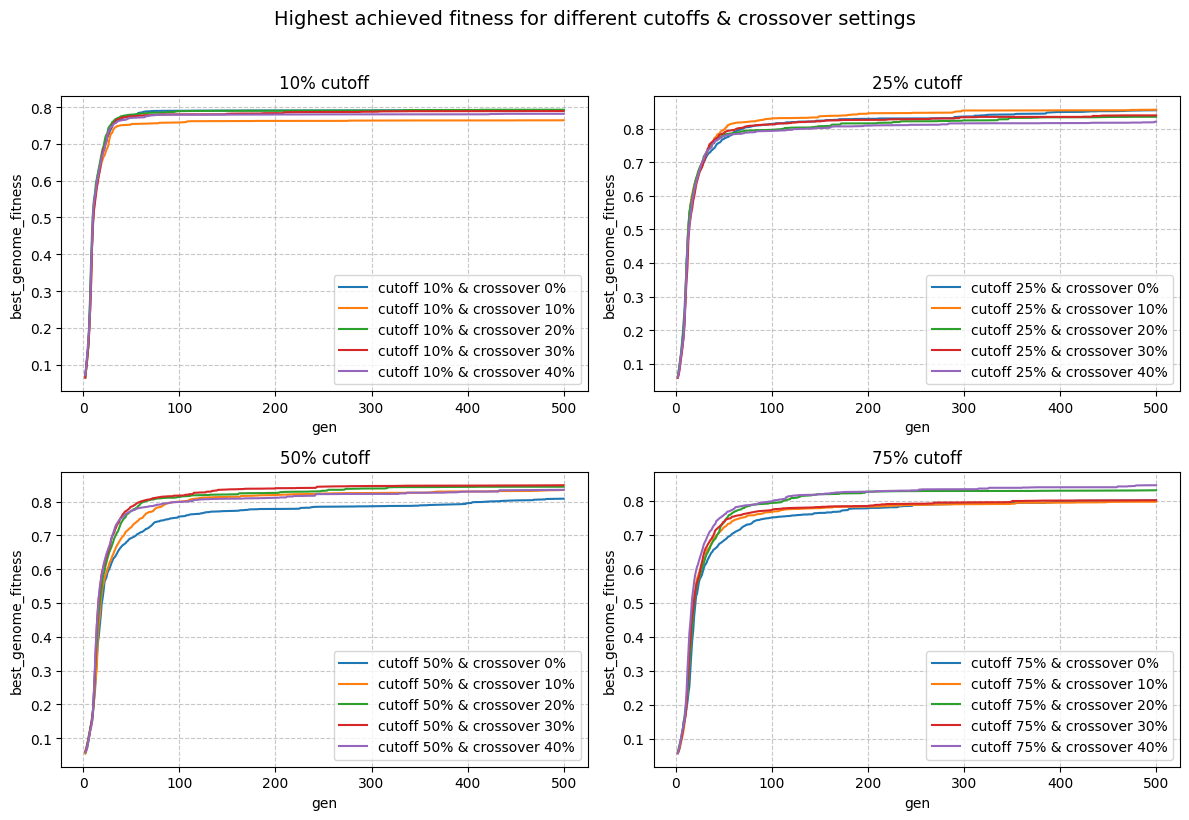

In [5]:
_ = sa.generalized_lineplot(crossover_plt_layout, crossover_data_sources, "best_genome_fitness", title="Highest achieved fitness for different cutoffs & crossover settings", subplt_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"])

In all of the selection strategy test setups, a fitness function was used that also considers the `num_arcs` metric, where a perfect score of 1.0 is not sensible to achieve - thus the overall fitness cannot reach 1.0.

Even though fitness seems to plateau on these graphs after ~100 gens, there is often a long tail of optimizations that should not be discarded - even though it is barely visible in these zoomed-out graphs. Examples of such improvements include removing one superfluous arc, leading to a slightly better `num_arcs` score.

While there is not much of a difference between the fitness plots, the 75% cutoff (4. Quadrant) is very interesting.
Here, a higher crossover rate is relatively beneficial, and both the 40% and 20% crossover achieve the highest fitness scores.

The benefit of crossover to fitness will be later investigated in more detail in the section on mutations (**TODO**: add a reference to this section here).


### Cutoff ~ Crossover - diversity & convergence

Now, I want to look at the interaction between cutoff and crossover when converging on the final set of components.
For this, I will plot the number of components discovered in each generation on average to see how quickly the search widens (again aggregating the two elitism settings for each cutoff/crossover combination).
Then I will plot the number of unique components, as selection pressure discards most components that are not useful.

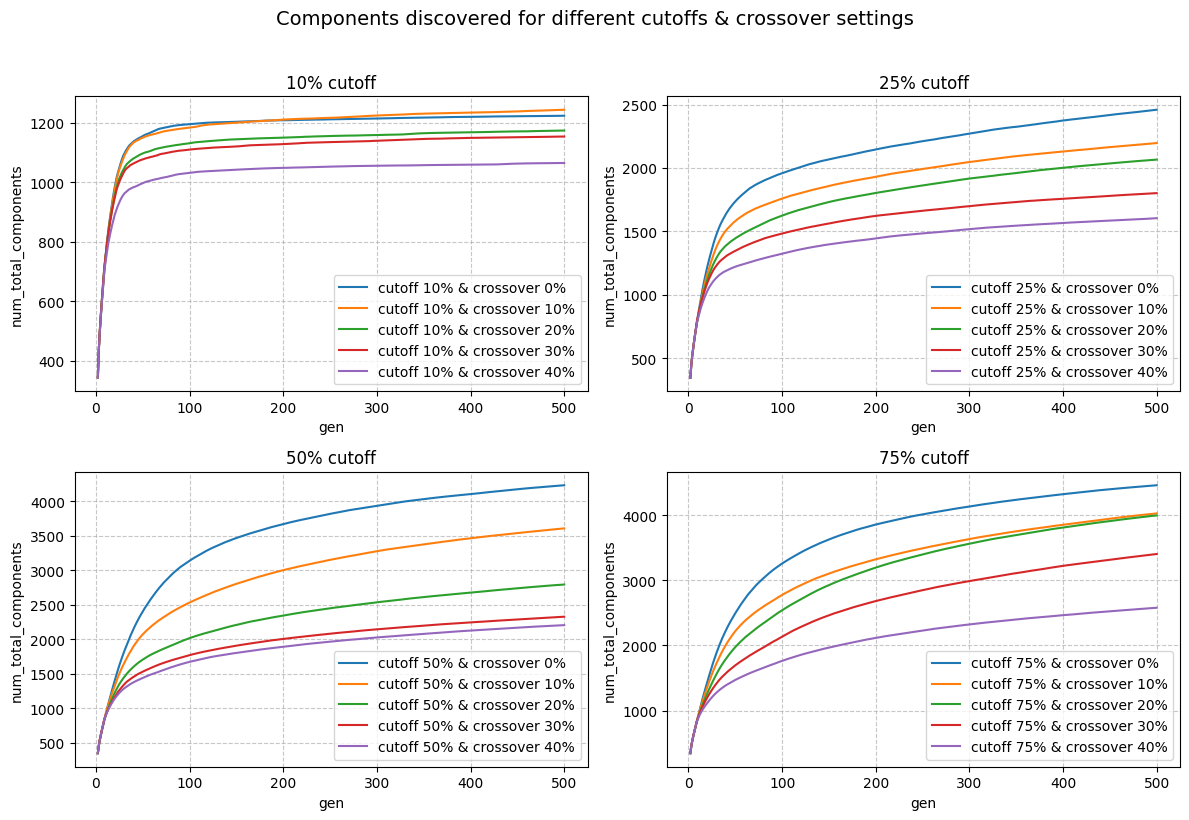

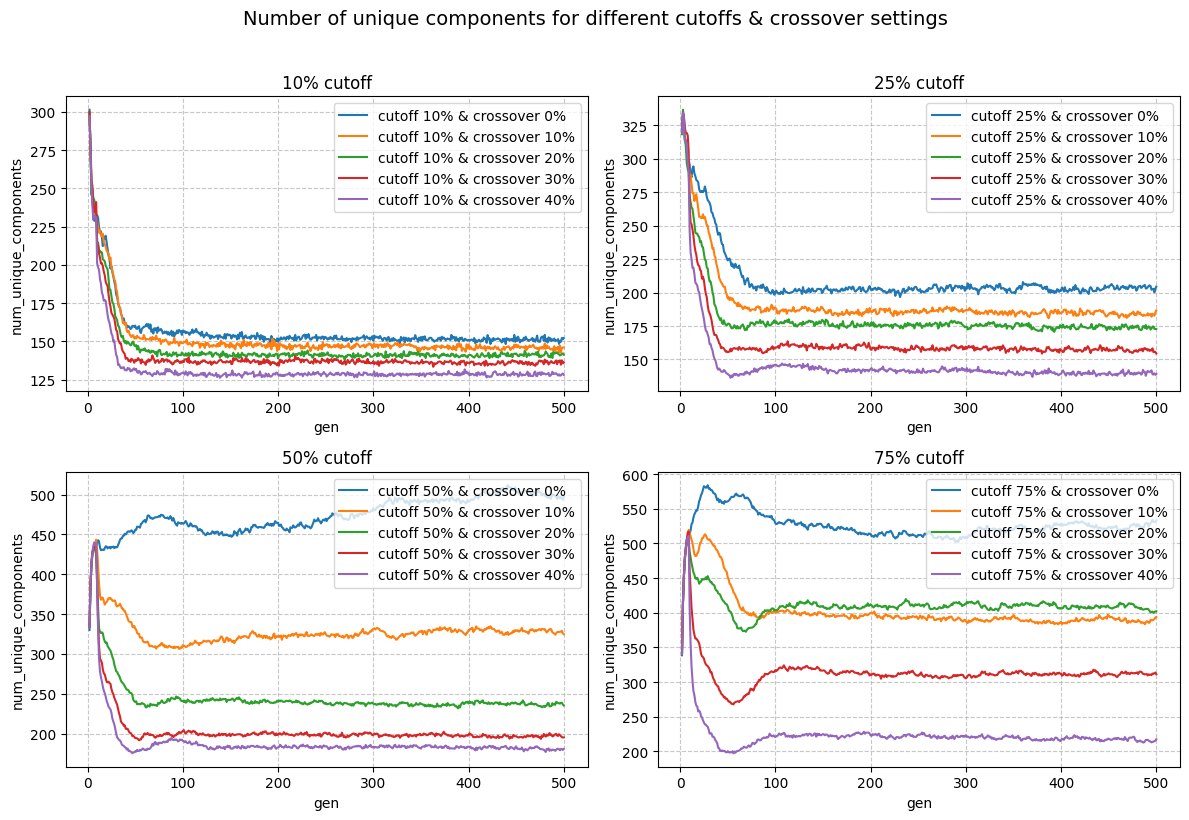

In [6]:
from copy import deepcopy
reload(sa)

# crossover components
_ = sa.generalized_lineplot(crossover_plt_layout, crossover_data_sources, "num_total_components", title="Components discovered for different cutoffs & crossover settings", subplt_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"])
_ = sa.generalized_lineplot(crossover_plt_layout, crossover_data_sources, "num_unique_components", title="Number of unique components for different cutoffs & crossover settings", subplt_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"], legend_loc="upper right")

**num components**
* Here the effect of the cutoff parameter can be seeen dramatically. As indicated in the regression, a low cutoff leads to much fewer components. However only a really low cutoff of 10% leads to an early plateau, all other cutoff levels continue to grow the number of components discovered, albeit more slowly for the lower cutoffs.
* Crossovers decreasing effect is also clearly visible here

**unique components**
* Independent of the chosen cutoff setting, all graphs show that there are roughly ~300 components in the first generation. All graphs generally decrease in the number of unique components and then plateau (one exception: 0% crossover, 50% cutoff - at least for the observed number of generations). The difference is how long it takes until this stagnation starts
    * With a low spawn cutoff (10% & 25%), the diversity starts to decrease pretty much at the start.
    * With a higher cutoff (50% & 75%), the diversity continues to rise for longer. and there are more unique components both at the peak and also towards the end of the run.
    * I think the decline in unique componenets starts as soon as the population starts to improve. Because it takes much longer to filter for good genomes with a high cutoff, the selection pressure on components is lower for a longer amount of time. That it takes longer to improve in fitness with a high cutoff is self-evident, but it can also be seen in the next graphs which plot fitness.

* The negative effect of crossover on diversity becomes very visible, especially in the 4th. Quadrant. Crossover is only enabled after 10 generations, after which pretty much all setups except the 0% crossover start to immediately decline, and based on the crossover rate, the decline in the number of unique components is stronger the higher the chosen crossover.

**Calculating the total number of possible components:**
I think the total number of possible components can be calculated by considering all the connection that a place may have to transitions (not considering nets with hidden transitions here). For each transition there are three possibilities when connecting to a place:
* no connection
* outgoing
* incoming
The algorithm prevents symmetric connections between places and transitions, thus the number of possible connections and thus also components should be:

$3^{\sum transitions} = 3^{8} = 6561$ 

The setups with >= 50% cutoffs thus reach about half the search space with a population size of 500 within 500 generations, i.e. 250.000 models (though a lot of them share components or are elite spawns). This shows that the selection pressure does indeed work to stop the algorithm from just testing every random connection.



### Cutoff ~ elitism - diversity, convergence & fitness
After investigating the relation of crossover and cutoff, lets do the same for elitism.

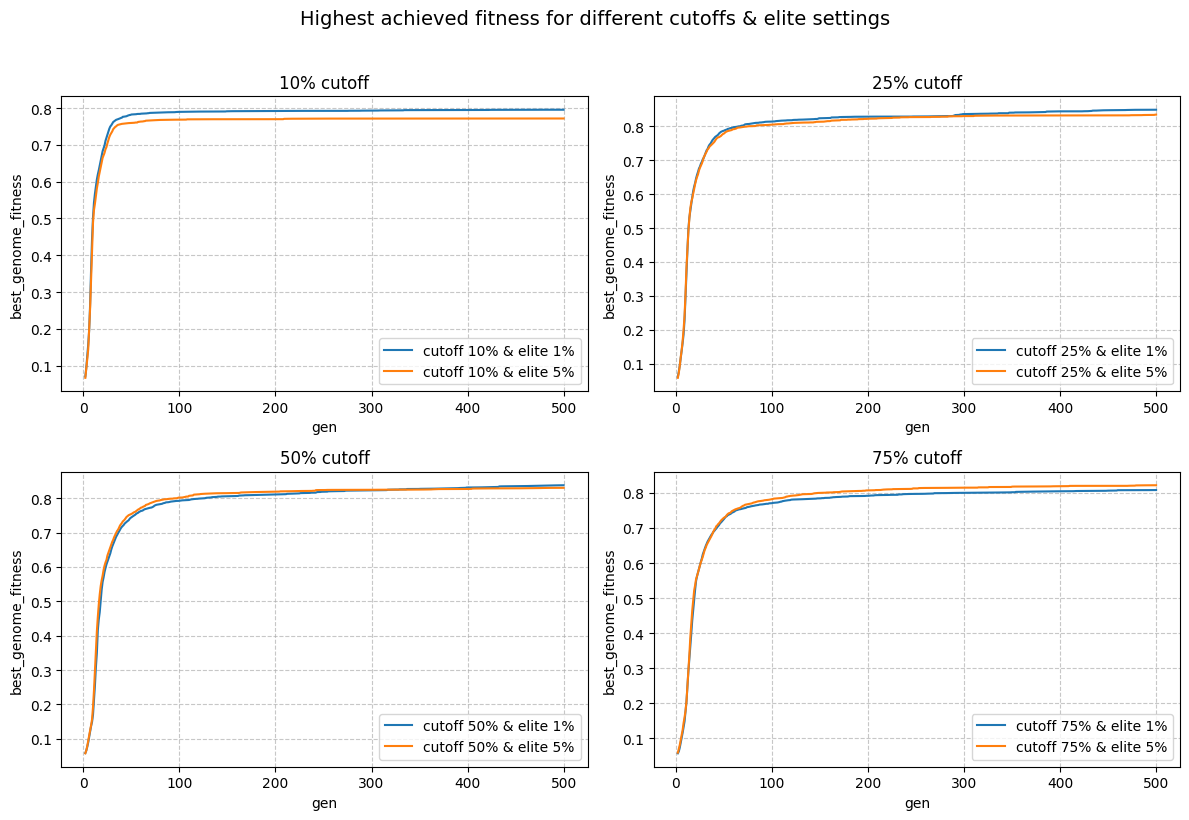

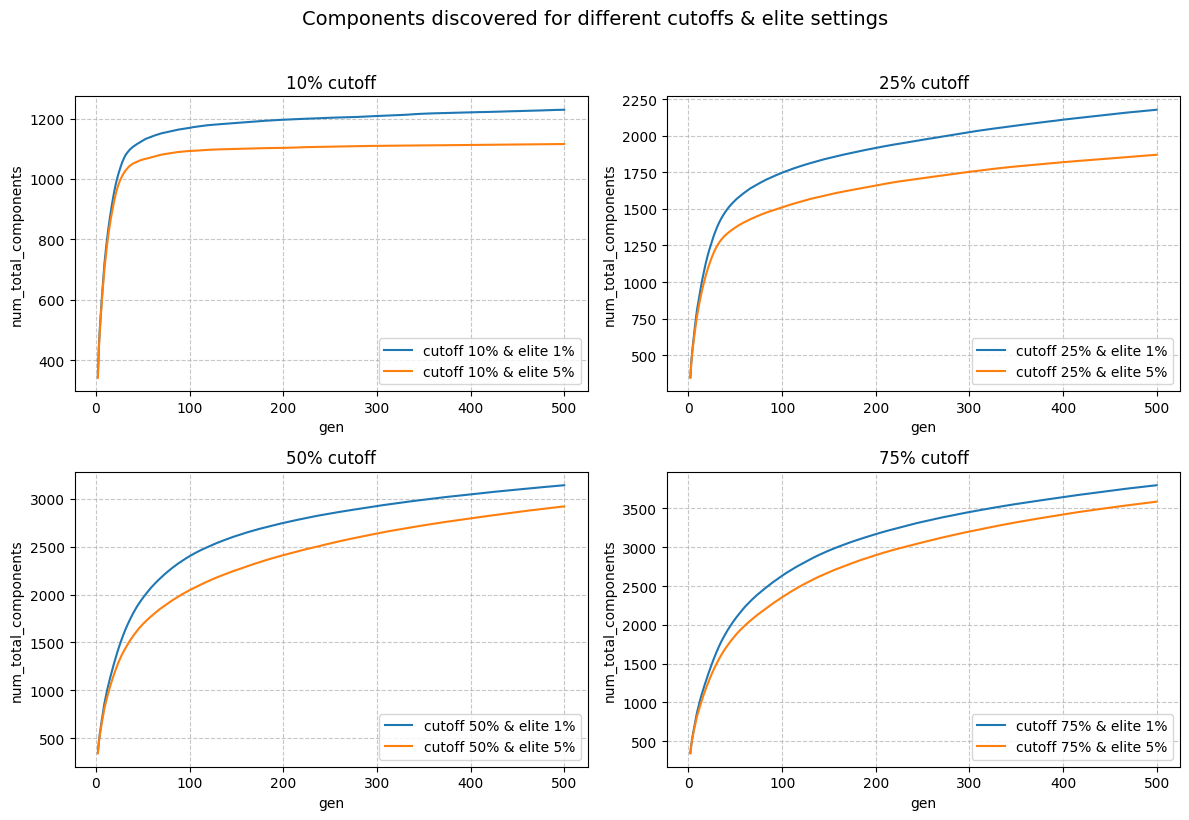

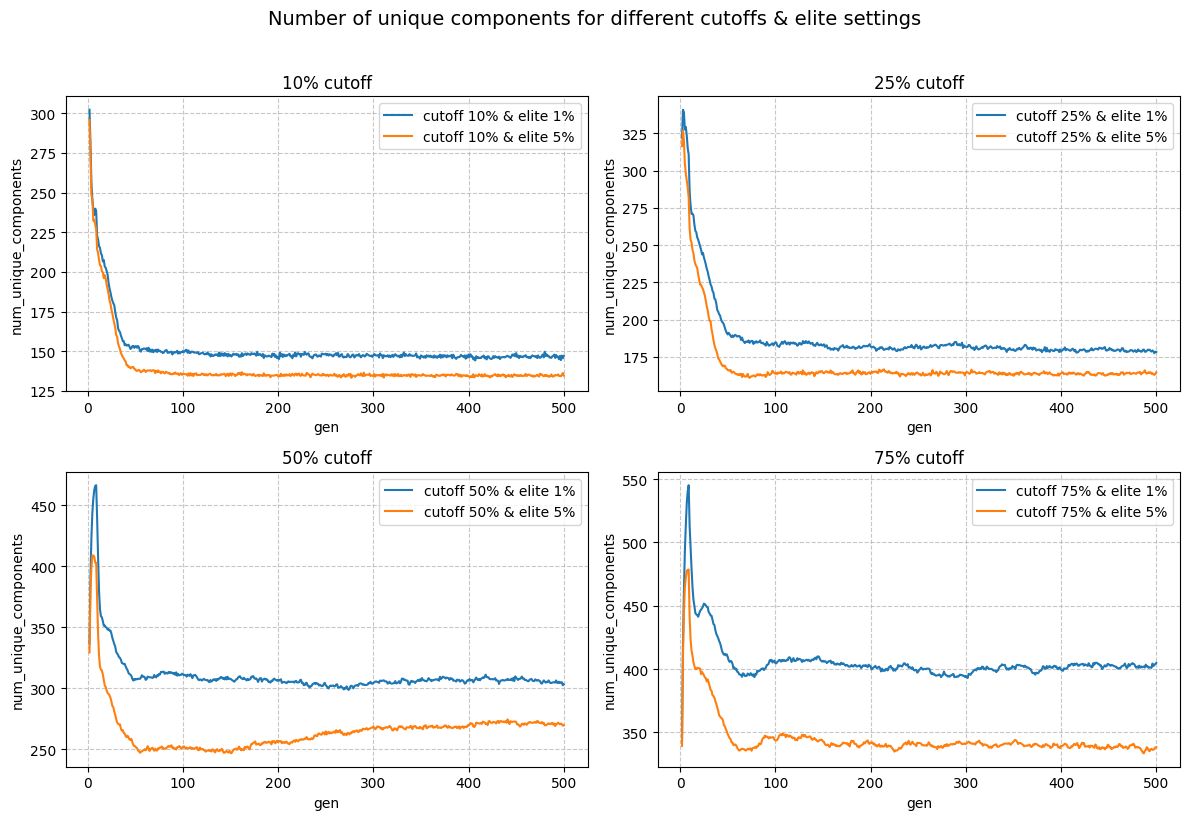

In [7]:
_ = sa.generalized_lineplot(elite_plt_layout, elite_data_sources, "best_genome_fitness", title="Highest achieved fitness for different cutoffs & elite settings", subplt_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"])
_ = sa.generalized_lineplot(elite_plt_layout, elite_data_sources, "num_total_components", title="Components discovered for different cutoffs & elite settings", subplt_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"])
_ = sa.generalized_lineplot(elite_plt_layout, elite_data_sources, "num_unique_components", title="Number of unique components for different cutoffs & elite settings", subplt_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"], legend_loc="upper right")

This time, the plots tell a consistent story:

**fitness:**
* cutoffs 0.1, 0.25, 0.5: lower elitism -> very slightly higher fitness 
* cutoff 0.75: higher elitism -> very slightly higher fitness 

**num components:**
* lower elitism -> more components discovered

**unique components:**
* lower elitism -> more components preserved for longer

### Truncation spawn plots
The following plots show the distribution of spawns each fitness rank gets. I.e. I rank the previous generation by fitness in descending order, then check the current generations parent ids and increment the number of spawns the parents fitness rank got. This means that it is just the parents position in the fitness ranking matters, and the plot effectively shows what fraction of the entire population gets to procreate.

The spawn rank plots shown here are from setups using 1% elitism, all 4 cutoff settings, as well as either 0% or 30% crossover, resulting in 8 plots.

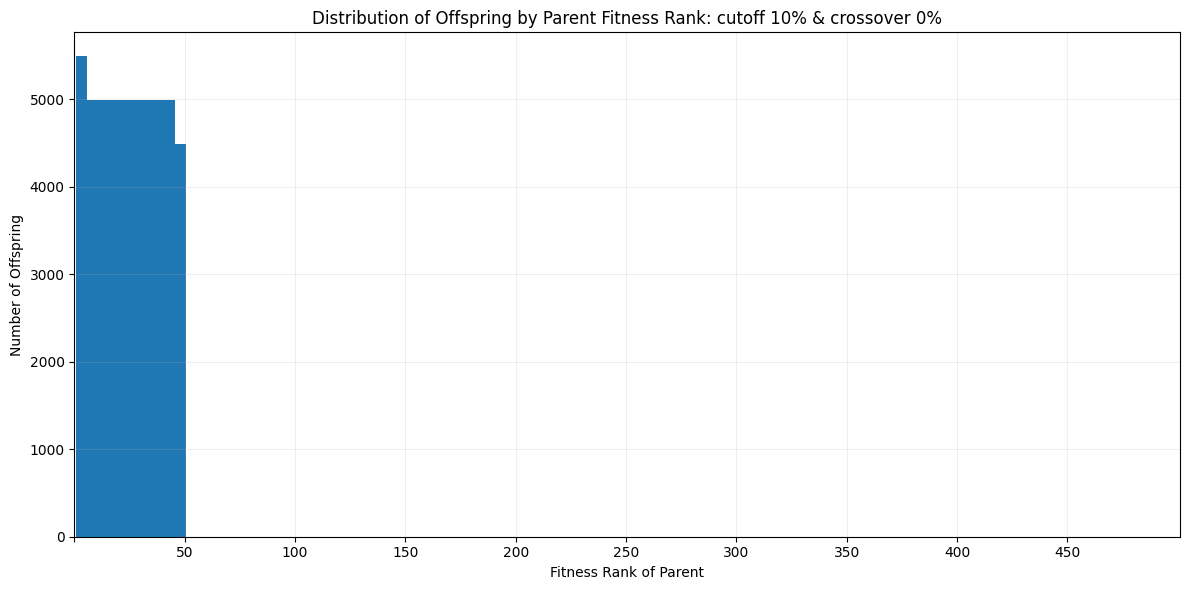

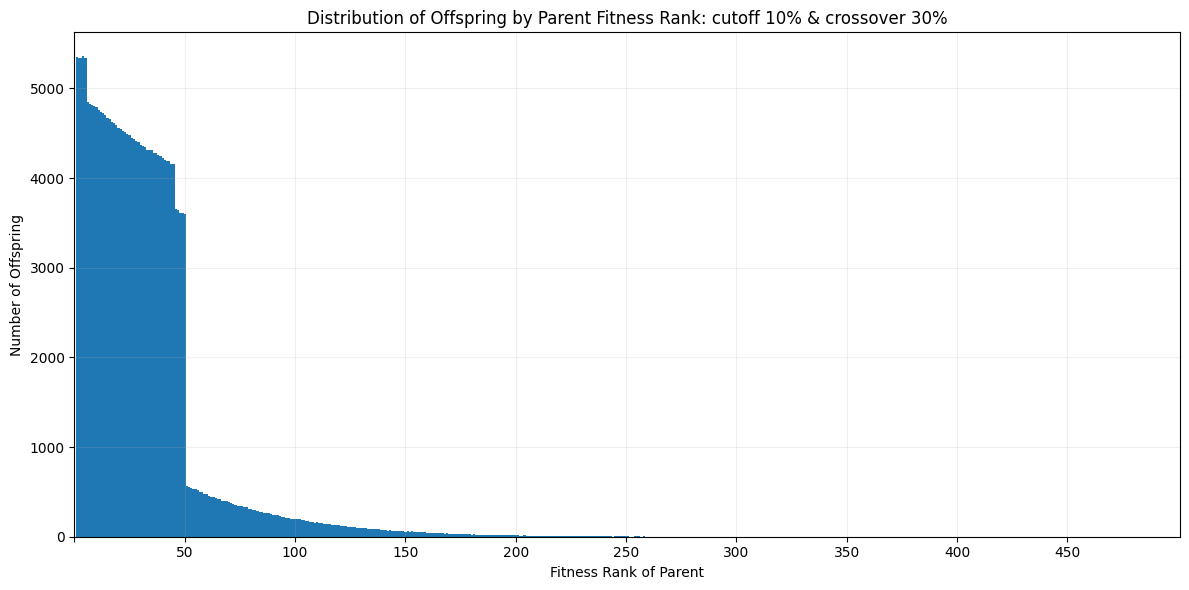

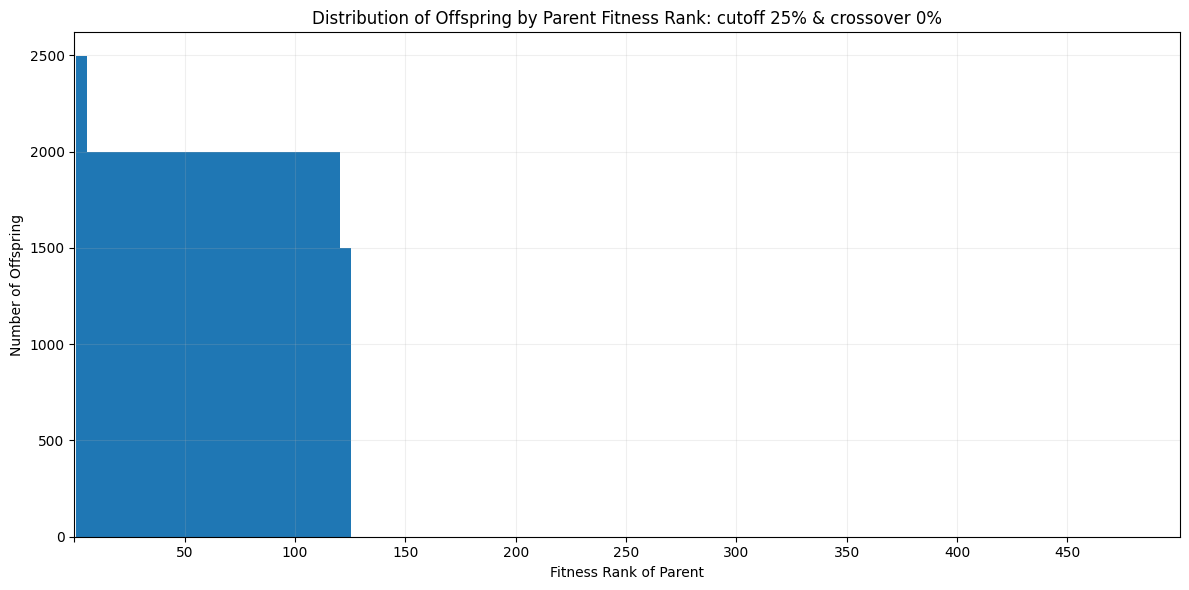

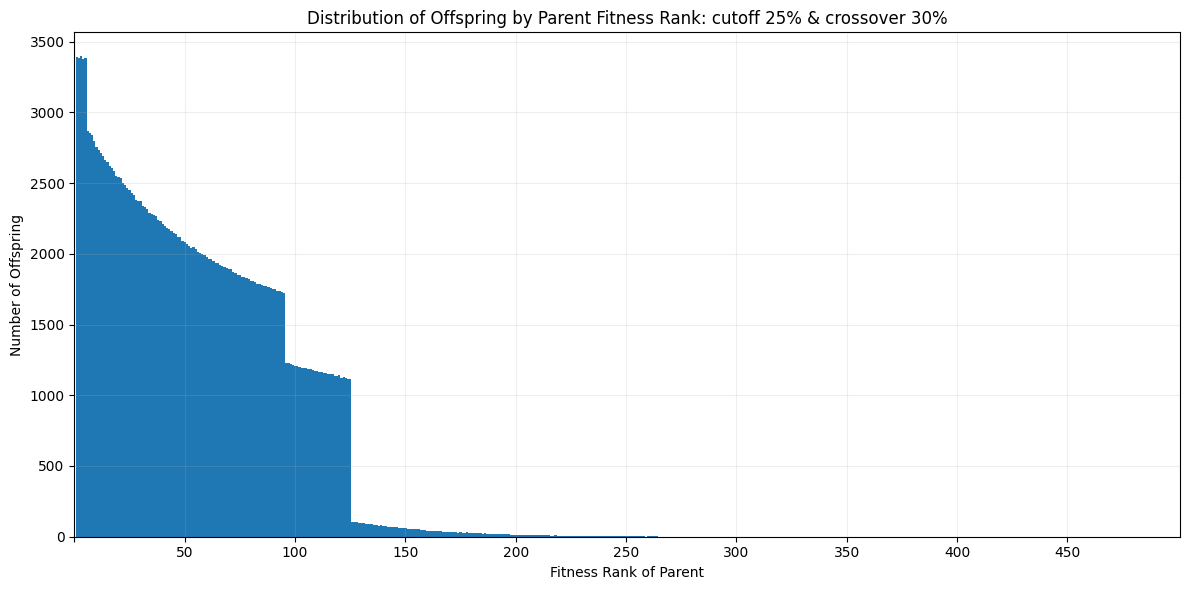

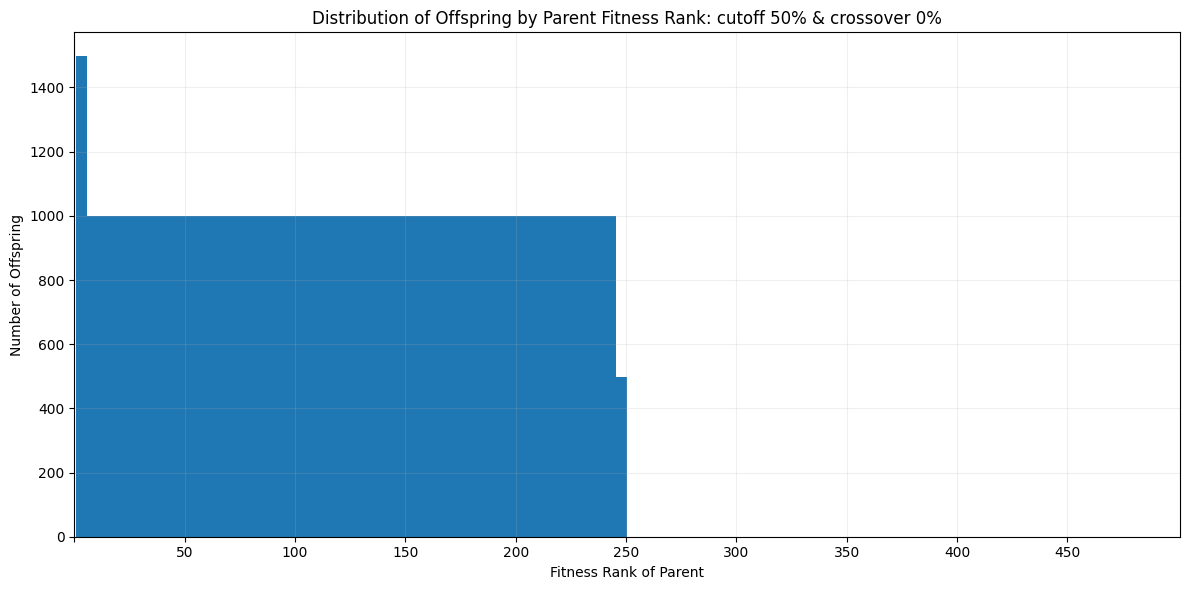

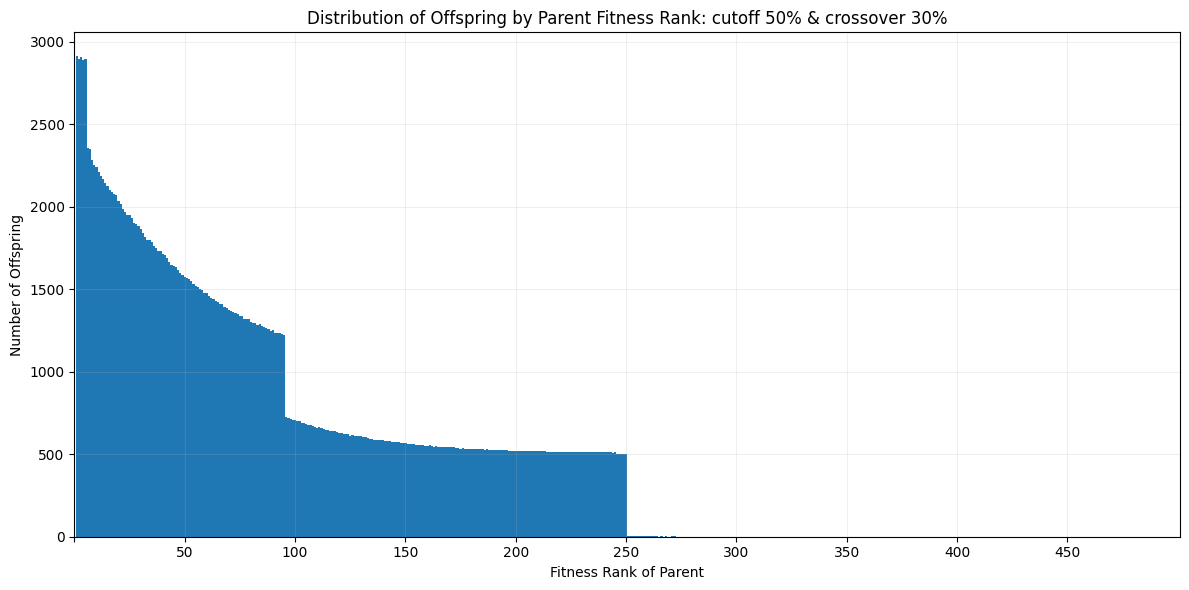

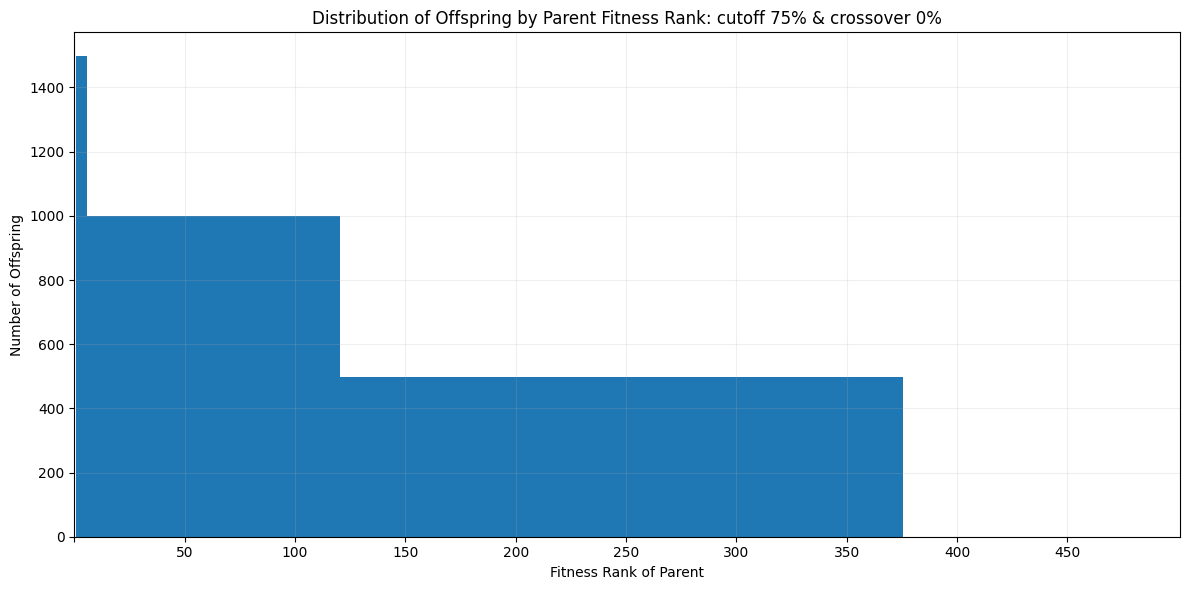

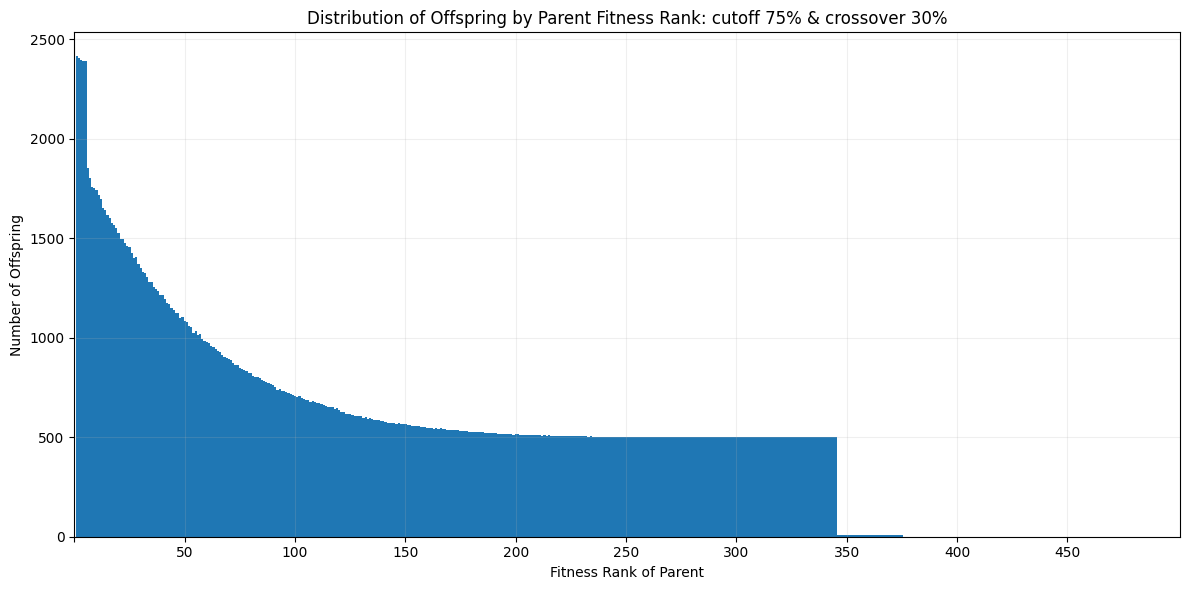

In [8]:
from copy import deepcopy
reload(sa)

chosen_setups = [
    "cutoff 10% & crossover 0%", "cutoff 10% & crossover 30%",
    "cutoff 25% & crossover 0%", "cutoff 25% & crossover 30%",
    "cutoff 50% & crossover 0%", "cutoff 50% & crossover 30%",
    "cutoff 75% & crossover 0%", "cutoff 75% & crossover 30%"
]

# using a fixed 0.01 elitism rate
search_params = {}
for d_id in chosen_setups:
    data = deepcopy(cutoff_crossover_search[d_id])
    data["pop_perc_elite"] = 0.01
    search_params[d_id] = data

# filtering for the setups containing these settings and plotting their aggregated spawn ranks
t = 'Distribution of Offspring by Parent Fitness Rank: '
search_res = sa.search_setups(res, search_params)
for s_name, s_id in sorted(search_res.items(), key= lambda x: x[0]):
    rs_data = res["setups"][s_id[0]]['spawn_rank_agg']
    sa.plot_offspring_distribution(rs_data, title=t+s_name)

**Spawn rank plot observations:**  
The first two plots show a 10% cutoff. With no crossover, it is really only the first 50 genomes that get to spawn. The first spike in the barplot is the result of the 5 elites. The small chip at the end of the bar is because the iteration of the remaining asex spawns could not quite finish.

When using crossover, the distribution caused by tournament selection is stacked on top of the normal cutoff selection. With a low cutoff of just 10%, the tail of crossover distribution extends out of the truncated section of the population.

This basic pattern continues for all other cutoff plots as well. With 25% cutoff, exactly the top 125 genomes get to spawn offspring, at 50% It is exactly half the population at 250, and with 75%, 375 members of the population get to spawn.

At 75%, the effect of iterating with modulo over the population becomes very visible. The first spawn loop iteration spawns 375 genomes. Add to that 5 elite spawns, that leaves 500 - 380 = 120 spawns for the second iteration when using no crossover. With crossover of 30%, the asex spawns are only 500*0.7=350 to begin with, allowing for just about that many asex spawns, and there is no visible step in the histogram. Thus crossover further intensivies elitism, because the second iteration of the spawn loop after all selected genomes had their first asex spawn becomes shorter.

Another thing that can be seen in those spawn rank plots is that with an increasing fraction of the population that gets to spawn into the next generation, the delta between the number of offspring the elites get relative to the rest of the spawning population becomes even more pronounced, as a higher cutoff leads to fewer spawns per member that makes the cutoff.

### Truncation - Overall results comparison
Lastly, I will look at the maximum fitness achieved by each setup - aggregated across all 20 runs and sorted by the mean of the aggregate to identify the best setups.

In [9]:
max_fitness_results = sa.get_best_setups(res["final_report"])
max_fitness_results.head(10)

setupname,mean_fitness,max_fitness,median_fitness,std_fitness
str,f64,f64,f64,f64
"""setup_12""",0.874216,0.903509,0.903509,0.060692
"""setup_11""",0.869983,0.903509,0.893939,0.056047
"""setup_40""",0.861852,0.903509,0.891304,0.057745
"""setup_24""",0.86062,0.903509,0.903509,0.074118
"""setup_22""",0.852567,0.903509,0.888986,0.069148
"""setup_28""",0.85086,0.903509,0.888986,0.063484
"""setup_14""",0.849953,0.903509,0.886667,0.061867
"""setup_25""",0.844953,0.903509,0.888986,0.06832
"""setup_16""",0.840538,0.903509,0.883536,0.071115


**Disclaimer about fitness values**
As already suggested by the linear regression - the effects of the tested parameters on fitness are not that big in absolute numbers. However, we have to consider that the range of possible fitness in my normalized fitness function is just 0-1, so so a difference in mean fitness of about 3,5% between the best and 10th. best should be considered when selecting parameters. Especially because the fitness function is also weighted more heavily towards the aggregated replay fitness which alone does not tell the complete story about a model's quality. And while the num-arcs score cannot reach perfect fitness, even small differences of one or two arcs more or less can have a huge impact on both a models performance on unseen trace variants not in the log, as well as readability.

Thus I want to pay attention to these results, even though the numeric differences are pretty small.

The parameter configurations for each setup can be obtained from the `data/truncation_test/param_changes.txt` file.

**Results**
* All but 4 selection strategies managed to discover the optimum process model for the simple log (max fitness = 0.903509), which is encouraging.
* The best two setups according to their mean achieved fitness (12 & 11) both use 25% cutoff and 1% elitism, with setup 12 using 10% crossover spawns and 11 using no crossover. This seems consistent with the testing thus far, and this result can also be seen in the [barplots showing the mean fitness](#interaction-cutoff--crossover-on-absolute-fitness-and-number-of-components-at-the-end-of-run).
* The 3rd best setup follows the radically different strategy of using a 75% spawn cutoff but with 40% crossover and 5% elitism, indicating that the crossover's tournament selection method almost acts as a sort of elitism, buffering against the fitness decline that results from using a high cutoff as is the case with setups 31-40.
* Setup 24 offers a middle ground, using 50% cutoff, but also 30% crossover (1% elites). Setup 22 is simillar, but it uses just 10% elitism
* the rest of the top 10 uses either 25% or 50% cutoff. None of the 10% cutoff setups are present in the top ten, and the only 75% cutoff that made the cut is setup 40.

### Truncation selection - summarized findings
Since all the parameters are in theory continuous, I could not test every possible value - nor would that have been productive. It seems that discarding about 75% of the population while keeping a very small number of elites and crossover spawns yields the best results for truncation selection.

At least for this small log, there does not really seem to be a relation between total search space coverage (i.e. total num components discovered) and achieved fitness, which is why a more focused search yields the best results. This does make sense, there is a combinatorial explosion of possible components, and with the simple log just consisting of 8 unique tasks and no necessity for hidden transitions, it is encouraging that a search space coverage of less than 50% percent ([total components: ~6.500](#cutoff--crossover---diversity--convergence)) is generally a good path for finding the optimum.

Next, I will investigate the roulette selection strategy.

## Selection strategy - roulette
For the roulette selection strategy there is no cutoff that needs to be manually set. The likelihood of spawning an offspring is directly dependant on a genomes fitness relative to the rest of the population. Numpys weighted random choice function is used, the weights being calculatd on a genomes share of fitness relative to the total population.
The "roulette" analogy comes from spinning a roulette wheel, where the segments sizes are adjusted according to the fitness.
Except for cutoff, the same parameter permutations were used:
* `pop_perc_elite`: 0.01, 0.05
* `pop_perc_crossover`: 0.0, 0.1, 0.2, 0.3, 0.4

resulting in 2 * 5 = just 10 setups.

### Regression on roulette parameters
Again, the first step is a regression on the chosen parameters. I expect the parameters to have very similar effects to those they had with truncation selection.

In [10]:
# crawl the results data and load it into a dict
roulette_res = sa.exec_results_crawler("../analysis/data/roulette_test")

Processing setup directories: 0it [00:00, ?it/s]

Processing setup directories: 13it [00:00, 99.21it/s]


Found cached results for setup_1
Successfully loaded cached results for setup_1

Found cached results for setup_10
Successfully loaded cached results for setup_10

Found cached results for setup_2
Successfully loaded cached results for setup_2

Found cached results for setup_3
Successfully loaded cached results for setup_3

Found cached results for setup_4
Successfully loaded cached results for setup_4

Found cached results for setup_5
Successfully loaded cached results for setup_5

Found cached results for setup_6
Successfully loaded cached results for setup_6

Found cached results for setup_7
Successfully loaded cached results for setup_7

Found cached results for setup_8
Successfully loaded cached results for setup_8

Found cached results for setup_9
Successfully loaded cached results for setup_9


In [11]:
roulette_regression = sa.run_regression(roulette_res, ["pop_perc_elite", "pop_perc_crossover"]);


Regression Results for num_components
--------------------------------------------------
R-squared: 0.8761
Adjusted R-squared: 0.8749

Standardized Coefficients:
pop_perc_elite        -359.6100 (p=0.0000)
pop_perc_crossover    -258.3556 (p=0.0000)

Regression Results for max_fitness
--------------------------------------------------
R-squared: 0.0890
Adjusted R-squared: 0.0798

Standardized Coefficients:
pop_perc_elite           0.0167 (p=0.0005)
pop_perc_crossover       0.0125 (p=0.0094)


**num components**  
Very similar R-Squared for the number of components. Both predictors for num_components are significant. This time elitism had a slightly more negative effect than crossover, while for truncation, the negative effect of crossover was 4 times stronger than elitism. But increasing both parameters predictably decreases the number of components.

**max fitness**  
Both parameters have a (very small) positive effect on fitness of about 1% each. Only elitism's effect is significant though. This is also in contrast to truncation selection, where elitism has a negative effect on fitness (at least when using more than 1%).

**On crossover**  
It should be noted here that crossover in the roulette selection functions differently than in the truncation and speciation selection methods. Both use a tournament selection to find mates, whereas the roulette selection method simply uses the weighted probabilities again for selecting two mates. Thus a difference in the effectiveness of crossover for roulette could be at least partially explained by the difference in how parents are selected for crossover.

### Interaction crossover ~ elitism on absolute fitness and number of components at the end of run
This time, there are only two parameters that were tested, meaning I can easily visualize their effects using simple barplots. Thus there are also no aggregations of the other parameter settings as was the case with elitism/crossover in truncation visualizations.

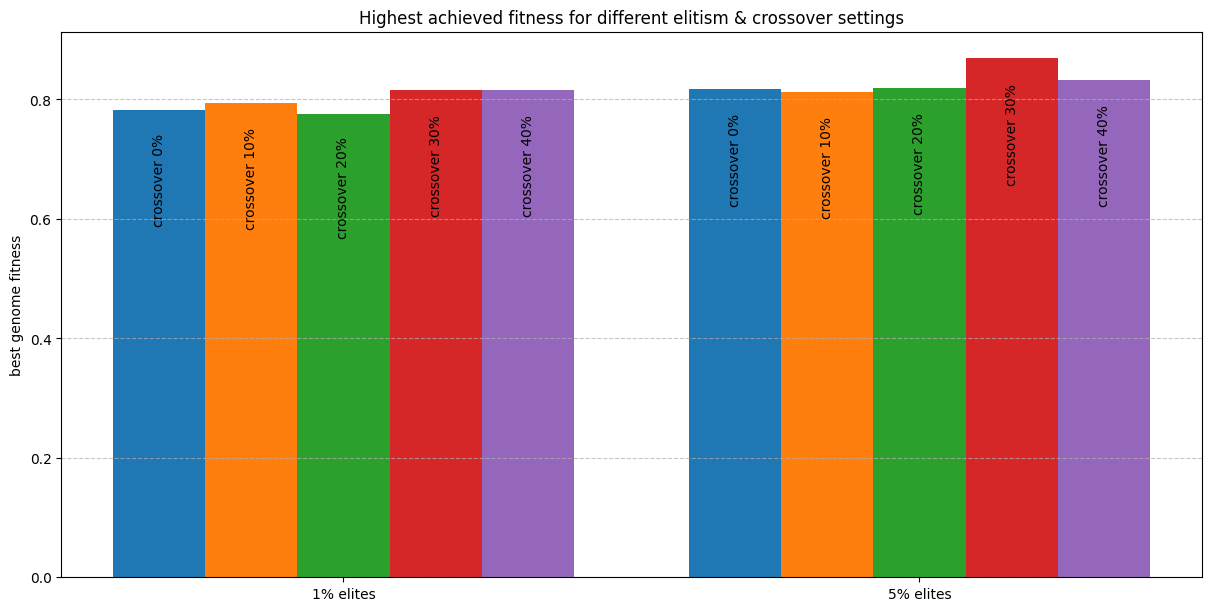

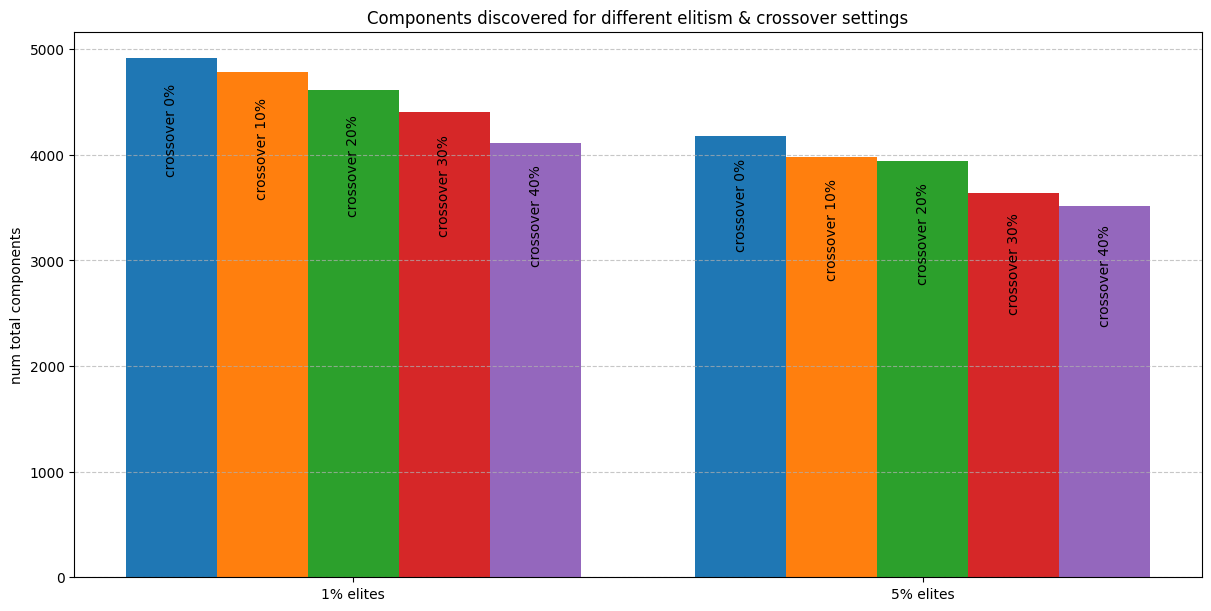

In [12]:
roulette_search = {
    "crossover 0% & elite 1%": {"pop_perc_crossover": 0.0 , "pop_perc_elite": 0.01}, "crossover 0% & elite 5%": {"pop_perc_crossover": 0.0 , "pop_perc_elite": 0.05}, 
    "crossover 10% & elite 1%": {"pop_perc_crossover": 0.10, "pop_perc_elite": 0.01}, "crossover 10% & elite 5%": {"pop_perc_crossover": 0.10 , "pop_perc_elite": 0.05}, 
    "crossover 20% & elite 1%": {"pop_perc_crossover": 0.20, "pop_perc_elite": 0.01}, "crossover 20% & elite 5%": {"pop_perc_crossover": 0.20, "pop_perc_elite": 0.05}, 
    "crossover 30% & elite 1%": {"pop_perc_crossover": 0.30, "pop_perc_elite": 0.01}, "crossover 30% & elite 5%": {"pop_perc_crossover": 0.30, "pop_perc_elite": 0.05}, 
    "crossover 40% & elite 1%": {"pop_perc_crossover": 0.40, "pop_perc_elite": 0.01}, "crossover 40% & elite 5%": {"pop_perc_crossover": 0.40, "pop_perc_elite": 0.05}, 
}


roulette_plt_layout = [
    ["crossover 0% & elite 1%", "crossover 10% & elite 1%", "crossover 20% & elite 1%", "crossover 30% & elite 1%", "crossover 40% & elite 1%"],
    ["crossover 0% & elite 5%", "crossover 10% & elite 5%", "crossover 20% & elite 5%", "crossover 30% & elite 5%", "crossover 40% & elite 5%"]
]

 
strip_second_param = lambda l: l.split('&')[0].strip().split('\n')[0] # lambda to be applied on labels
roulette_data_sources = sa.search_and_aggregate_param_results(roulette_res, roulette_search)
_ = sa.generalized_barplot(roulette_plt_layout, roulette_data_sources, "best_genome_fitness", title="Highest achieved fitness for different elitism & crossover settings", group_titles=["1% elites", "5% elites"], label_lambda=strip_second_param)
_ = sa.generalized_barplot(roulette_plt_layout, roulette_data_sources, "num_total_components", title="Components discovered for different elitism & crossover settings", group_titles=["1% elites", "5% elites"], label_lambda=strip_second_param)

Again, an inverse relation between the fitness and number of components discovered can be seen. While higher elitism leads to fewer components discovered, it also leads to higher fitness. But the fitness difference is not much. Overall the components plot also suggests that roulette selection selects from a much larger subset of the population, as it averaged a relatively high number of components discovered in 500 generations. The 0% crossover, 1% elites combination leads to close to 5.000 components discovered, which is roughly 75% percent of possible components.

### elitism ~ crossover - fitness
First, lets look at the fitness progression when using the different crossover and fitness settings

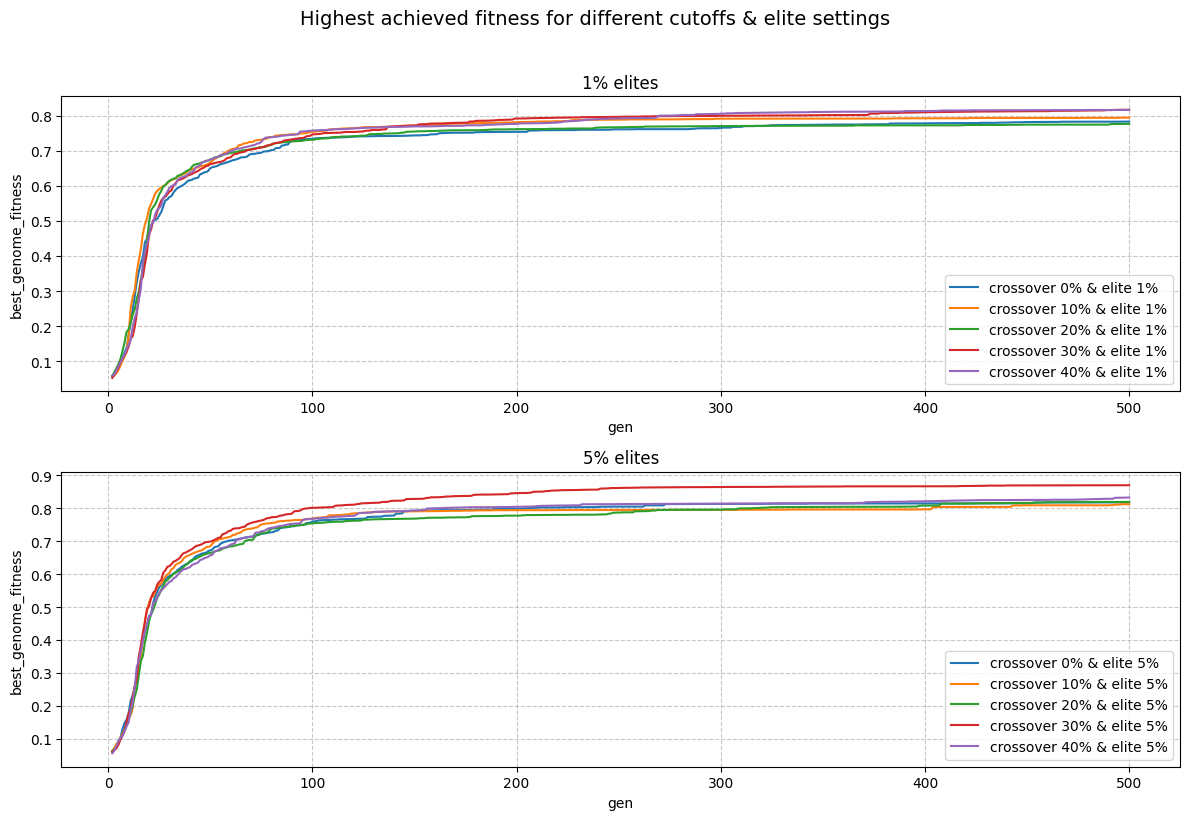

In [13]:
_ = sa.generalized_lineplot(roulette_plt_layout, roulette_data_sources, "best_genome_fitness", title="Highest achieved fitness for different cutoffs & elite settings", subplt_titles=["1% elites", "5% elites"])

Not much of a difference, though it becomes visible that with a higher degree of elitism, roulette convergess earlier on a high fitness. Also, the only notable setup difference here is the much better fitness performance of 30% crossover when using 5% elitism, whose line is pretty seperated from the other setups. It also seems that this setup was the best overall, as can be seen in the barcharts above. The setup comparison at the end will reveal just how much better this setup is than all other tested setups.

### elitism ~ crossover - diversity, convergence
Next I will look again at the search space coverage and convergence on a set of components.

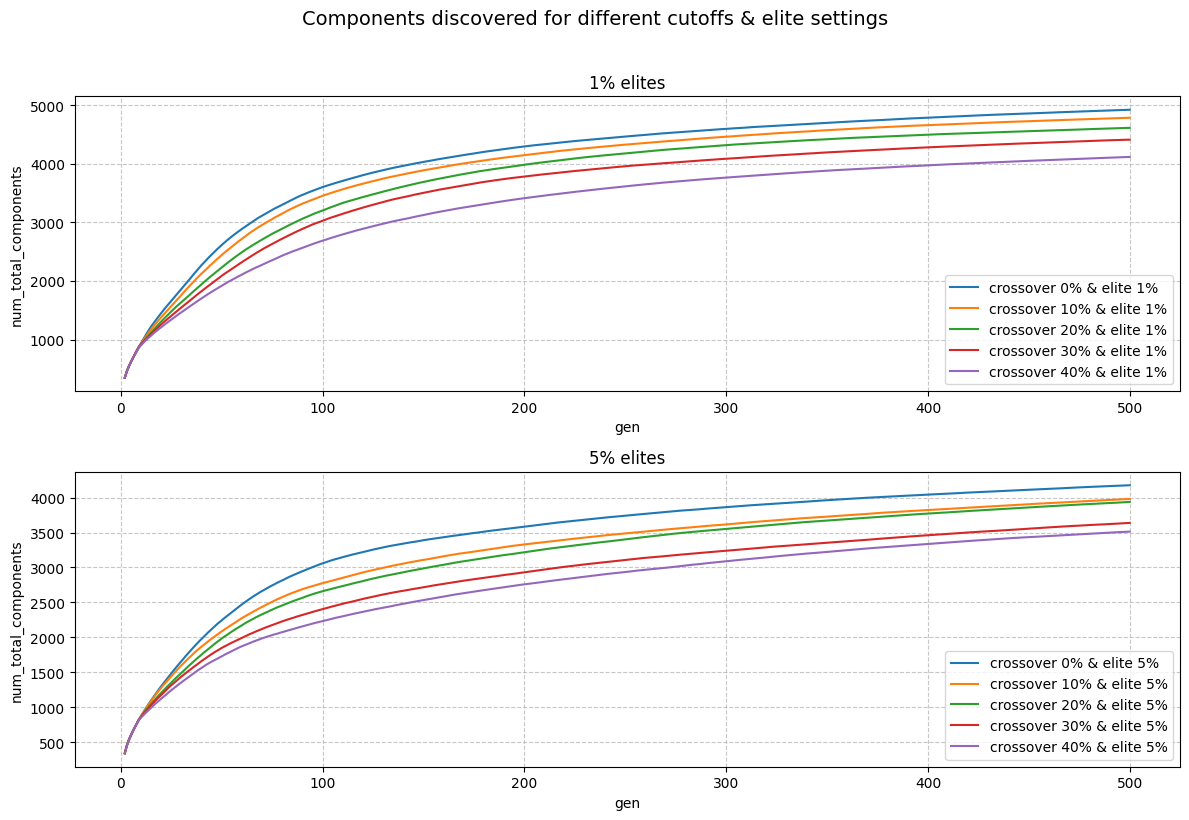

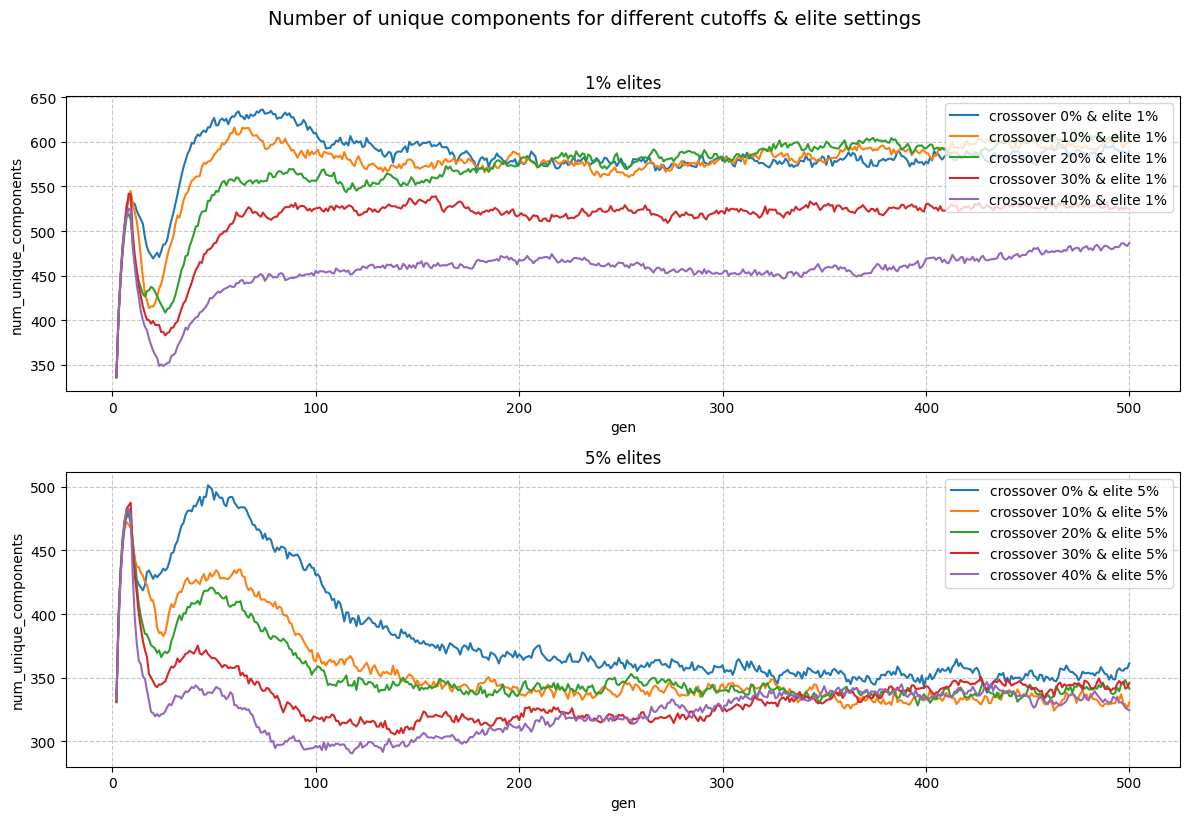

In [14]:
_ = sa.generalized_lineplot(roulette_plt_layout, roulette_data_sources, "num_total_components", title="Components discovered for different cutoffs & elite settings", subplt_titles=["1% elites", "5% elites"])
_ = sa.generalized_lineplot(roulette_plt_layout, roulette_data_sources, "num_unique_components", title="Number of unique components for different cutoffs & elite settings", subplt_titles=["1% elites", "5% elites"], legend_loc="upper right")

**num components discovered**  
The graphs make the negative relation between crossover and total number of components discovered visible, both for 1% and 5% elitism, increasing the number of crossover spawns leads to fewer components.

**num unique components per generation**  
Higher crossover rates generally lead to a lower number of unique components. However the effect of elitism on the number of unique components seems stronger, even though it is only a 4% increase, compared to the total 40% delta between highest and lowest crossover rates. At 5% elitism, after 300 generations it barely makes a difference which crossover setting is used, they all plateau at around ~350 components.

Also, the the curve of unique components per generation is interesting. Since 5% elitism generally leads to quicker convergence on good genomes (as can be seen in the [fitness graphs](#elitism--crossover---fitness)), the decline of unqiue compoents starts earlier in the bottom graph using 5% elitism.

### Roulette spawn plots
As for truncation selection, here I plot the spawn ranks of different setups. Again, I only visualize the setups with 1% elitism

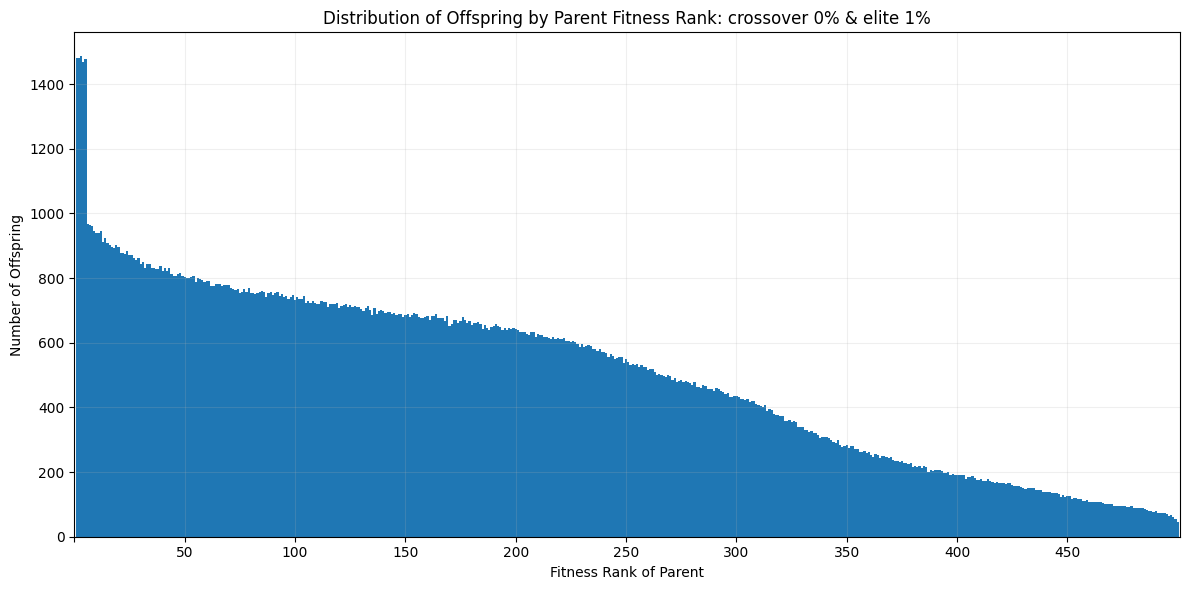

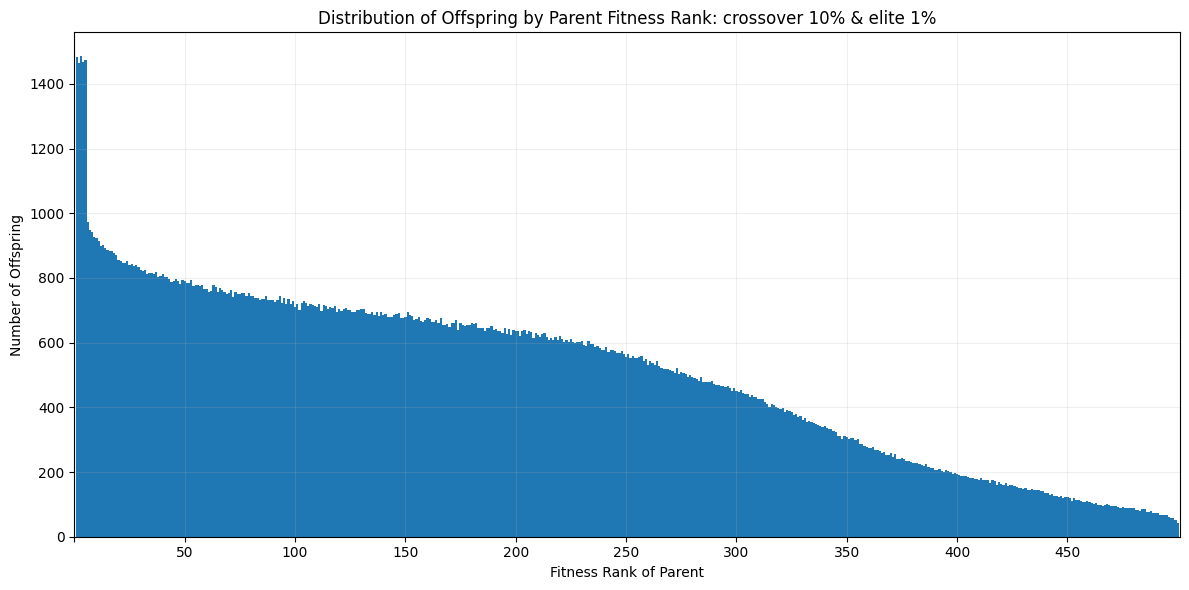

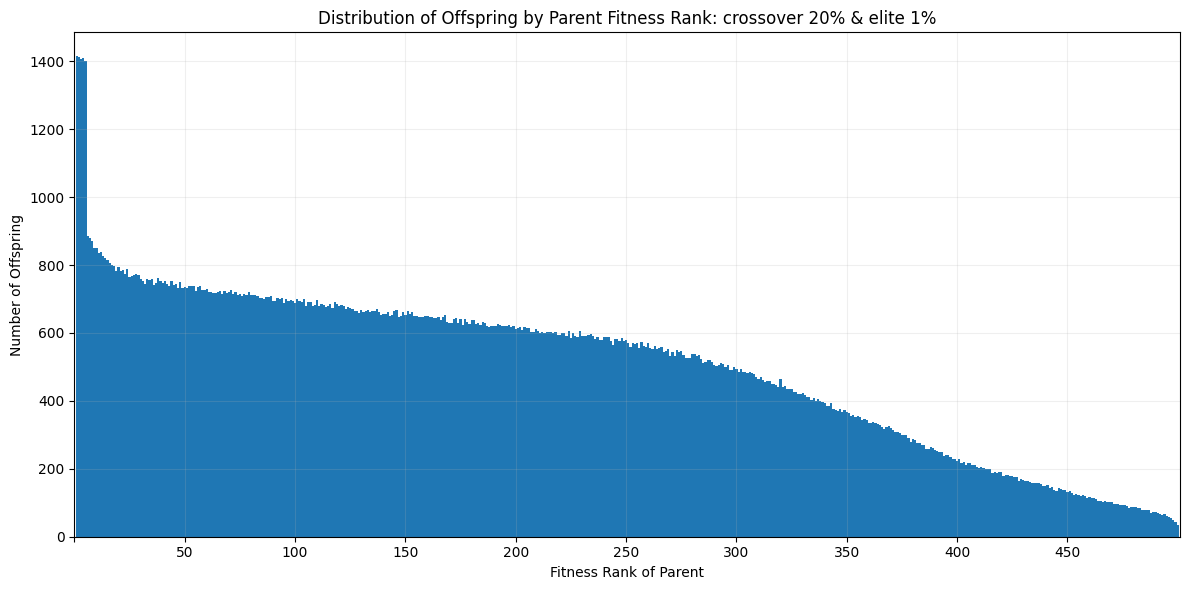

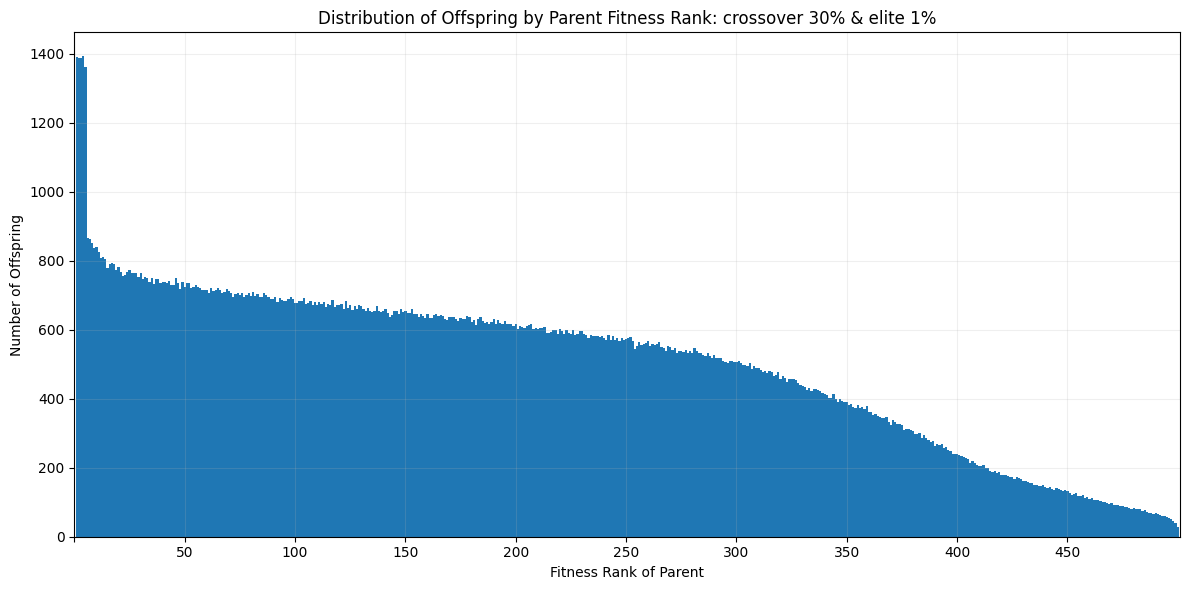

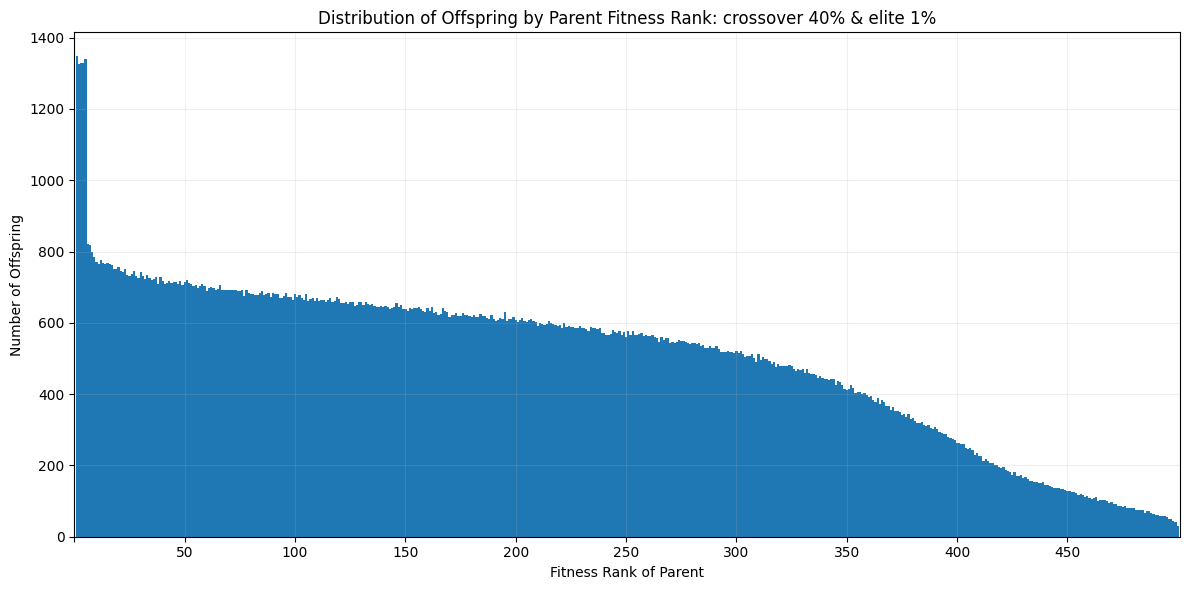

In [15]:
# only plotting 1% elitism
roulette_sr = ["crossover 0% & elite 1%", "crossover 10% & elite 1%", "crossover 20% & elite 1%", "crossover 30% & elite 1%", "crossover 40% & elite 1%"]
roulette_sr_search = {n: roulette_search[n] for n in roulette_sr}

t = 'Distribution of Offspring by Parent Fitness Rank: '
for s_name, s_id in sorted(sa.search_setups(roulette_res, roulette_sr_search).items(), key= lambda x: x[0]):
    rs_data = roulette_res["setups"][s_id[0]]['spawn_rank_agg']
    sa.plot_offspring_distribution(rs_data, title=t+s_name)

**Spawn rank plot observations**  
On first glance, there is hardly any difference between the plots. However, when looking at them in detail, one can see that with increasing crossover rates, the distribution becomes less heavy on the left side, e.g. with 0% crossover, almost all of the top 50 genomes get to spawn more than 800 offspring over a whole run, while at 40% crossover - with exception of the elite spawns - the top 50 spawn less than 800 genomes on average.

It thus seems that roulette-based crossover's spawn selection distribution is flatter. Thats about it for the differences between the plots.

Compared to truncation selection, the roulette's spawn selections' tail reaches all the way to the end of the distribution. It is also a reflection of the distribution of relative fitness among the population, as this is what determines the spawns. Looking at it from this lense, we can see that for the first ~350 genomes, the fitness decreases, but only slightly. After that, the rate of the decline increases a bit. This does not really suggest that the first ~350 genomes are that much fitter than the last ~150 - I would assume they are all pretty bad. **TODO: add reference to best vs. avg. fitness comparisons**. However it does show that the fitness differences within most of the population are pretty small.

### Roulette - Overall results comparison
As a last step, I want to identify the best setup. The fitness plots would suggest this to be 30% crossover with 5% elitism

In [16]:
roulette_fitness_results = sa.get_best_setups(roulette_res["final_report"])
roulette_fitness_results

setupname,mean_fitness,max_fitness,median_fitness,std_fitness
str,f64,f64,f64,f64
"""setup_9""",0.870063,0.903509,0.894065,0.053811
"""setup_10""",0.832869,0.903509,0.856967,0.072317
"""setup_8""",0.819275,0.903509,0.837828,0.069322
"""setup_6""",0.817839,0.896825,0.814547,0.067619
"""setup_4""",0.816489,0.903509,0.812495,0.063141
"""setup_5""",0.815801,0.903509,0.824509,0.071996
"""setup_7""",0.812401,0.903509,0.810001,0.072702
"""setup_2""",0.793853,0.903509,0.767175,0.070014
"""setup_1""",0.782706,0.880952,0.794814,0.058586


**Results**
* Only the top 3 setups managed to discover the optimum process model for the simple log (max fitness = 0.903509), and there is overall a much bigger difference among the setups when compared to truncation selection. The best setup is 4% better than the second best and almost 10% better than the worst.
* The setups using 5% elitism (6-10) dominate the charts, the best setup with 1% elitism is setup 4 with 1% elitism and 30% crossover in place 5. The only 5% elitism setup that ranks among the 1%ers is setup 7, with a crossover rate of 10% - all other 5%ers do much better.
* Maybe it would have been interesting to test with more than 5% elitism, but this made the comparison to truncation easier, and vastly reduced the number of setups that I needed to run & test. Also, more than 5% elitism does seem a bit excessive and the results from truncation did not suggest to me that there would have been a benefit in increasing elitism much for the roulette strategy. I think the best setup (9) using 5% elitism with a 30% crossover rate hits the sweet spot

### Roulette selection - summarized findings
In contrast to the truncation selection method, when using roulette there is a clear benefit to elitism. There is also a benefit in using crossover, though that benefit seems to be very unique to the 5% elitism 30% crossover combination. Why it is exactly this combination that hits the sweetspot and not say 5%elite and 20% or 40% crossover is unclear to me at the moment, but it does seem important to have a moderate amount of crossover to mix with the elitism.

Overall, the efficiency difference between the best truncation & roulette setups does not seem to be that much, with both having very comparable mean, median and stdev values.

## Speciation selection

Won't change
* `elitism`: True; False
* `enough_gens_to_change_things` because this should be more a part of mutation tests and I don't want to f*ck with different mutation rates/ annealing anyways

Change
* `species_boundary`: 0.8, 0.9, 0.95
* `pop_perc_crossover`: 0.0, 0.1, 0.2, 0.3, 0.4
* `spawn_cutoff`: 0.1, 0.25, 0.5, 0.75
* `species_component_pool_size`: 1, 5, 10
* `allowed_gens_no_improvement`: 50, inf

In [17]:
from importlib import reload # TODO: remove this later
import scripts.helper_scripts.setup_analysis as sa # helper module for fetching setup analysis
reload(sa)
# crawl the results data and load it into a dict
speciation_res = sa.exec_results_crawler("../analysis/data/speciation_test")

Processing setup directories: 17it [00:00, 166.28it/s]


Found cached results for setup_1
Successfully loaded cached results for setup_1

Found cached results for setup_10
Successfully loaded cached results for setup_10

Found cached results for setup_100
Successfully loaded cached results for setup_100

Found cached results for setup_101
Successfully loaded cached results for setup_101

Found cached results for setup_102
Successfully loaded cached results for setup_102

Found cached results for setup_103
Successfully loaded cached results for setup_103

Found cached results for setup_104
Successfully loaded cached results for setup_104

Found cached results for setup_105
Successfully loaded cached results for setup_105

Found cached results for setup_106
Successfully loaded cached results for setup_106

Found cached results for setup_107
Successfully loaded cached results for setup_107

Found cached results for setup_108
Successfully loaded cached results for setup_108

Found cached results for setup_109
Successfully loaded cached results 

Processing setup directories: 34it [00:00, 95.67it/s] 

Successfully loaded cached results for setup_111

Found cached results for setup_112
Successfully loaded cached results for setup_112

Found cached results for setup_113
Successfully loaded cached results for setup_113

Found cached results for setup_114
Successfully loaded cached results for setup_114

Found cached results for setup_115
Successfully loaded cached results for setup_115

Found cached results for setup_116
Successfully loaded cached results for setup_116

Found cached results for setup_117
Successfully loaded cached results for setup_117

Found cached results for setup_118
Successfully loaded cached results for setup_118

Found cached results for setup_119
Successfully loaded cached results for setup_119

Found cached results for setup_12
Successfully loaded cached results for setup_12

Found cached results for setup_120
Successfully loaded cached results for setup_120

Found cached results for setup_121
Successfully loaded cached results for setup_121

Found cached resu

Processing setup directories: 46it [00:00, 80.84it/s]


Found cached results for setup_125
Successfully loaded cached results for setup_125

Found cached results for setup_126
Successfully loaded cached results for setup_126

Found cached results for setup_127
Successfully loaded cached results for setup_127

Found cached results for setup_128
Successfully loaded cached results for setup_128

Found cached results for setup_129
Successfully loaded cached results for setup_129

Found cached results for setup_13
Successfully loaded cached results for setup_13

Found cached results for setup_130
Successfully loaded cached results for setup_130

Found cached results for setup_131
Successfully loaded cached results for setup_131

Found cached results for setup_132
Successfully loaded cached results for setup_132

Found cached results for setup_133
Successfully loaded cached results for setup_133

Found cached results for setup_134
Successfully loaded cached results for setup_134

Found cached results for setup_135
Successfully loaded cached resu

Processing setup directories: 64it [00:00, 75.18it/s]

Successfully loaded cached results for setup_138

Found cached results for setup_139
Successfully loaded cached results for setup_139

Found cached results for setup_14
Successfully loaded cached results for setup_14

Found cached results for setup_140
Successfully loaded cached results for setup_140

Found cached results for setup_141
Successfully loaded cached results for setup_141

Found cached results for setup_142
Successfully loaded cached results for setup_142

Found cached results for setup_143
Successfully loaded cached results for setup_143

Found cached results for setup_144
Successfully loaded cached results for setup_144

Found cached results for setup_145
Successfully loaded cached results for setup_145

Found cached results for setup_146
Successfully loaded cached results for setup_146

Found cached results for setup_147
Successfully loaded cached results for setup_147

Found cached results for setup_148
Successfully loaded cached results for setup_148

Found cached resu

Processing setup directories: 80it [00:01, 73.07it/s]

Successfully loaded cached results for setup_151

Found cached results for setup_152
Successfully loaded cached results for setup_152

Found cached results for setup_153
Successfully loaded cached results for setup_153

Found cached results for setup_154
Successfully loaded cached results for setup_154

Found cached results for setup_155
Successfully loaded cached results for setup_155

Found cached results for setup_156
Successfully loaded cached results for setup_156

Found cached results for setup_157
Successfully loaded cached results for setup_157

Found cached results for setup_158
Successfully loaded cached results for setup_158

Found cached results for setup_159
Successfully loaded cached results for setup_159

Found cached results for setup_16
Successfully loaded cached results for setup_16

Found cached results for setup_160
Successfully loaded cached results for setup_160

Found cached results for setup_161
Successfully loaded cached results for setup_161

Found cached resu

Processing setup directories: 96it [00:01, 73.11it/s]


Found cached results for setup_166
Successfully loaded cached results for setup_166

Found cached results for setup_167
Successfully loaded cached results for setup_167

Found cached results for setup_168
Successfully loaded cached results for setup_168

Found cached results for setup_169
Successfully loaded cached results for setup_169

Found cached results for setup_17
Successfully loaded cached results for setup_17

Found cached results for setup_170
Successfully loaded cached results for setup_170

Found cached results for setup_171
Successfully loaded cached results for setup_171

Found cached results for setup_172
Successfully loaded cached results for setup_172

Found cached results for setup_173
Successfully loaded cached results for setup_173

Found cached results for setup_174
Successfully loaded cached results for setup_174

Found cached results for setup_175
Successfully loaded cached results for setup_175

Found cached results for setup_176
Successfully loaded cached resu

Processing setup directories: 104it [00:01, 71.29it/s]

Successfully loaded cached results for setup_179

Found cached results for setup_18
Successfully loaded cached results for setup_18

Found cached results for setup_180
Successfully loaded cached results for setup_180

Found cached results for setup_181
Successfully loaded cached results for setup_181

Found cached results for setup_182
Successfully loaded cached results for setup_182

Found cached results for setup_183
Successfully loaded cached results for setup_183

Found cached results for setup_184
Successfully loaded cached results for setup_184

Found cached results for setup_185
Successfully loaded cached results for setup_185

Found cached results for setup_186
Successfully loaded cached results for setup_186

Found cached results for setup_187
Successfully loaded cached results for setup_187

Found cached results for setup_188
Successfully loaded cached results for setup_188

Found cached results for setup_189
Successfully loaded cached results for setup_189

Found cached resu

Processing setup directories: 120it [00:01, 71.55it/s]

Successfully loaded cached results for setup_19

Found cached results for setup_190
Successfully loaded cached results for setup_190

Found cached results for setup_191
Successfully loaded cached results for setup_191

Found cached results for setup_192
Successfully loaded cached results for setup_192

Found cached results for setup_193
Successfully loaded cached results for setup_193

Found cached results for setup_194
Successfully loaded cached results for setup_194

Found cached results for setup_195
Successfully loaded cached results for setup_195

Found cached results for setup_196
Successfully loaded cached results for setup_196

Found cached results for setup_197
Successfully loaded cached results for setup_197

Found cached results for setup_198
Successfully loaded cached results for setup_198

Found cached results for setup_199
Successfully loaded cached results for setup_199

Found cached results for setup_2
Successfully loaded cached results for setup_2

Found cached results

Processing setup directories: 136it [00:01, 69.93it/s]

Successfully loaded cached results for setup_202

Found cached results for setup_203
Successfully loaded cached results for setup_203

Found cached results for setup_204
Successfully loaded cached results for setup_204

Found cached results for setup_205
Successfully loaded cached results for setup_205

Found cached results for setup_206
Successfully loaded cached results for setup_206

Found cached results for setup_207
Successfully loaded cached results for setup_207

Found cached results for setup_208
Successfully loaded cached results for setup_208

Found cached results for setup_209
Successfully loaded cached results for setup_209

Found cached results for setup_21
Successfully loaded cached results for setup_21

Found cached results for setup_210
Successfully loaded cached results for setup_210

Found cached results for setup_211
Successfully loaded cached results for setup_211

Found cached results for setup_212
Successfully loaded cached results for setup_212

Found cached resu

Processing setup directories: 152it [00:02, 72.26it/s]


Found cached results for setup_215
Successfully loaded cached results for setup_215

Found cached results for setup_216
Successfully loaded cached results for setup_216

Found cached results for setup_217
Successfully loaded cached results for setup_217

Found cached results for setup_218
Successfully loaded cached results for setup_218

Found cached results for setup_219
Successfully loaded cached results for setup_219

Found cached results for setup_22
Successfully loaded cached results for setup_22

Found cached results for setup_220
Successfully loaded cached results for setup_220

Found cached results for setup_221
Successfully loaded cached results for setup_221

Found cached results for setup_222
Successfully loaded cached results for setup_222

Found cached results for setup_223
Successfully loaded cached results for setup_223

Found cached results for setup_224
Successfully loaded cached results for setup_224

Found cached results for setup_225
Successfully loaded cached resu

Processing setup directories: 168it [00:02, 75.58it/s]

Successfully loaded cached results for setup_23

Found cached results for setup_230
Successfully loaded cached results for setup_230

Found cached results for setup_231
Successfully loaded cached results for setup_231

Found cached results for setup_232
Successfully loaded cached results for setup_232

Found cached results for setup_233
Successfully loaded cached results for setup_233

Found cached results for setup_234
Successfully loaded cached results for setup_234

Found cached results for setup_235
Successfully loaded cached results for setup_235

Found cached results for setup_236
Successfully loaded cached results for setup_236

Found cached results for setup_237
Successfully loaded cached results for setup_237

Found cached results for setup_238
Successfully loaded cached results for setup_238

Found cached results for setup_239
Successfully loaded cached results for setup_239

Found cached results for setup_24
Successfully loaded cached results for setup_24

Found cached resul

Processing setup directories: 184it [00:02, 75.15it/s]

Successfully loaded cached results for setup_244

Found cached results for setup_245
Successfully loaded cached results for setup_245

Found cached results for setup_246
Successfully loaded cached results for setup_246

Found cached results for setup_247
Successfully loaded cached results for setup_247

Found cached results for setup_248
Successfully loaded cached results for setup_248

Found cached results for setup_249
Successfully loaded cached results for setup_249

Found cached results for setup_25
Successfully loaded cached results for setup_25

Found cached results for setup_250
Successfully loaded cached results for setup_250

Found cached results for setup_251
Successfully loaded cached results for setup_251

Found cached results for setup_252
Successfully loaded cached results for setup_252

Found cached results for setup_253
Successfully loaded cached results for setup_253

Found cached results for setup_254
Successfully loaded cached results for setup_254

Found cached resu

Processing setup directories: 200it [00:02, 74.13it/s]

Successfully loaded cached results for setup_259

Found cached results for setup_26
Successfully loaded cached results for setup_26

Found cached results for setup_260
Successfully loaded cached results for setup_260

Found cached results for setup_261
Successfully loaded cached results for setup_261

Found cached results for setup_262
Successfully loaded cached results for setup_262

Found cached results for setup_263
Successfully loaded cached results for setup_263

Found cached results for setup_264
Successfully loaded cached results for setup_264

Found cached results for setup_265
Successfully loaded cached results for setup_265

Found cached results for setup_266
Successfully loaded cached results for setup_266

Found cached results for setup_267
Successfully loaded cached results for setup_267

Found cached results for setup_268
Successfully loaded cached results for setup_268

Found cached results for setup_269
Successfully loaded cached results for setup_269

Found cached resu

Processing setup directories: 216it [00:02, 74.27it/s]

Successfully loaded cached results for setup_272

Found cached results for setup_273
Successfully loaded cached results for setup_273

Found cached results for setup_274
Successfully loaded cached results for setup_274

Found cached results for setup_275
Successfully loaded cached results for setup_275

Found cached results for setup_276
Successfully loaded cached results for setup_276

Found cached results for setup_277
Successfully loaded cached results for setup_277

Found cached results for setup_278
Successfully loaded cached results for setup_278

Found cached results for setup_279
Successfully loaded cached results for setup_279

Found cached results for setup_28
Successfully loaded cached results for setup_28

Found cached results for setup_280
Successfully loaded cached results for setup_280

Found cached results for setup_281
Successfully loaded cached results for setup_281

Found cached results for setup_282
Successfully loaded cached results for setup_282

Found cached resu

Processing setup directories: 232it [00:03, 73.97it/s]

Successfully loaded cached results for setup_287

Found cached results for setup_288
Successfully loaded cached results for setup_288

Found cached results for setup_289
Successfully loaded cached results for setup_289

Found cached results for setup_29
Successfully loaded cached results for setup_29

Found cached results for setup_290
Successfully loaded cached results for setup_290

Found cached results for setup_291
Successfully loaded cached results for setup_291

Found cached results for setup_292
Successfully loaded cached results for setup_292

Found cached results for setup_293
Successfully loaded cached results for setup_293

Found cached results for setup_294
Successfully loaded cached results for setup_294

Found cached results for setup_295
Successfully loaded cached results for setup_295

Found cached results for setup_296
Successfully loaded cached results for setup_296

Found cached results for setup_297
Successfully loaded cached results for setup_297

Found cached resu

Processing setup directories: 240it [00:03, 72.29it/s]

Successfully loaded cached results for setup_300

Found cached results for setup_301
Successfully loaded cached results for setup_301

Found cached results for setup_302
Successfully loaded cached results for setup_302

Found cached results for setup_303
Successfully loaded cached results for setup_303

Found cached results for setup_304
Successfully loaded cached results for setup_304

Found cached results for setup_305
Successfully loaded cached results for setup_305

Found cached results for setup_306
Successfully loaded cached results for setup_306

Found cached results for setup_307
Successfully loaded cached results for setup_307

Found cached results for setup_308
Successfully loaded cached results for setup_308

Found cached results for setup_309
Successfully loaded cached results for setup_309

Found cached results for setup_31
Successfully loaded cached results for setup_31

Found cached results for setup_310
Successfully loaded cached results for setup_310

Found cached resu

Processing setup directories: 256it [00:03, 72.14it/s]


Found cached results for setup_313
Successfully loaded cached results for setup_313

Found cached results for setup_314
Successfully loaded cached results for setup_314

Found cached results for setup_315
Successfully loaded cached results for setup_315

Found cached results for setup_316
Successfully loaded cached results for setup_316

Found cached results for setup_317
Successfully loaded cached results for setup_317

Found cached results for setup_318
Successfully loaded cached results for setup_318

Found cached results for setup_319
Successfully loaded cached results for setup_319

Found cached results for setup_32
Successfully loaded cached results for setup_32

Found cached results for setup_320
Successfully loaded cached results for setup_320

Found cached results for setup_321
Successfully loaded cached results for setup_321

Found cached results for setup_322
Successfully loaded cached results for setup_322

Found cached results for setup_323
Successfully loaded cached resu

Processing setup directories: 272it [00:03, 73.60it/s]

Successfully loaded cached results for setup_327

Found cached results for setup_328
Successfully loaded cached results for setup_328

Found cached results for setup_329
Successfully loaded cached results for setup_329

Found cached results for setup_33
Successfully loaded cached results for setup_33

Found cached results for setup_330
Successfully loaded cached results for setup_330

Found cached results for setup_331
Successfully loaded cached results for setup_331

Found cached results for setup_332
Successfully loaded cached results for setup_332

Found cached results for setup_333
Successfully loaded cached results for setup_333

Found cached results for setup_334
Successfully loaded cached results for setup_334

Found cached results for setup_335
Successfully loaded cached results for setup_335

Found cached results for setup_336
Successfully loaded cached results for setup_336

Found cached results for setup_337
Successfully loaded cached results for setup_337

Found cached resu

Processing setup directories: 288it [00:03, 74.41it/s]

Successfully loaded cached results for setup_341

Found cached results for setup_342
Successfully loaded cached results for setup_342

Found cached results for setup_343
Successfully loaded cached results for setup_343

Found cached results for setup_344
Successfully loaded cached results for setup_344

Found cached results for setup_345
Successfully loaded cached results for setup_345

Found cached results for setup_346
Successfully loaded cached results for setup_346

Found cached results for setup_347
Successfully loaded cached results for setup_347

Found cached results for setup_348
Successfully loaded cached results for setup_348

Found cached results for setup_349
Successfully loaded cached results for setup_349

Found cached results for setup_35
Successfully loaded cached results for setup_35

Found cached results for setup_350
Successfully loaded cached results for setup_350

Found cached results for setup_351
Successfully loaded cached results for setup_351

Found cached resu

Processing setup directories: 304it [00:04, 74.49it/s]


Found cached results for setup_357
Successfully loaded cached results for setup_357

Found cached results for setup_358
Successfully loaded cached results for setup_358

Found cached results for setup_359
Successfully loaded cached results for setup_359

Found cached results for setup_36
Successfully loaded cached results for setup_36

Found cached results for setup_360
Successfully loaded cached results for setup_360

Found cached results for setup_37
Successfully loaded cached results for setup_37

Found cached results for setup_38
Successfully loaded cached results for setup_38

Found cached results for setup_39
Successfully loaded cached results for setup_39

Found cached results for setup_4
Successfully loaded cached results for setup_4

Found cached results for setup_40
Successfully loaded cached results for setup_40

Found cached results for setup_41
Successfully loaded cached results for setup_41

Found cached results for setup_42
Successfully loaded cached results for setup_4

Processing setup directories: 320it [00:04, 70.87it/s]

Successfully loaded cached results for setup_44

Found cached results for setup_45
Successfully loaded cached results for setup_45

Found cached results for setup_46
Successfully loaded cached results for setup_46

Found cached results for setup_47
Successfully loaded cached results for setup_47

Found cached results for setup_48
Successfully loaded cached results for setup_48

Found cached results for setup_49
Successfully loaded cached results for setup_49

Found cached results for setup_5
Successfully loaded cached results for setup_5

Found cached results for setup_50
Successfully loaded cached results for setup_50

Found cached results for setup_51
Successfully loaded cached results for setup_51

Found cached results for setup_52
Successfully loaded cached results for setup_52

Found cached results for setup_53
Successfully loaded cached results for setup_53

Found cached results for setup_54
Successfully loaded cached results for setup_54

Found cached results for setup_55
Succes

Processing setup directories: 336it [00:04, 73.44it/s]

Successfully loaded cached results for setup_58

Found cached results for setup_59
Successfully loaded cached results for setup_59

Found cached results for setup_6
Successfully loaded cached results for setup_6

Found cached results for setup_60
Successfully loaded cached results for setup_60

Found cached results for setup_61
Successfully loaded cached results for setup_61

Found cached results for setup_62
Successfully loaded cached results for setup_62

Found cached results for setup_63
Successfully loaded cached results for setup_63

Found cached results for setup_64
Successfully loaded cached results for setup_64

Found cached results for setup_65
Successfully loaded cached results for setup_65

Found cached results for setup_66
Successfully loaded cached results for setup_66

Found cached results for setup_67
Successfully loaded cached results for setup_67

Found cached results for setup_68
Successfully loaded cached results for setup_68

Found cached results for setup_69
Succes

Processing setup directories: 352it [00:04, 73.96it/s]

Successfully loaded cached results for setup_72

Found cached results for setup_73
Successfully loaded cached results for setup_73

Found cached results for setup_74
Successfully loaded cached results for setup_74

Found cached results for setup_75
Successfully loaded cached results for setup_75

Found cached results for setup_76
Successfully loaded cached results for setup_76

Found cached results for setup_77
Successfully loaded cached results for setup_77

Found cached results for setup_78
Successfully loaded cached results for setup_78

Found cached results for setup_79
Successfully loaded cached results for setup_79

Found cached results for setup_8
Successfully loaded cached results for setup_8

Found cached results for setup_80
Successfully loaded cached results for setup_80

Found cached results for setup_81
Successfully loaded cached results for setup_81

Found cached results for setup_82
Successfully loaded cached results for setup_82

Found cached results for setup_83
Succes

Processing setup directories: 368it [00:04, 75.62it/s]

Successfully loaded cached results for setup_86

Found cached results for setup_87
Successfully loaded cached results for setup_87

Found cached results for setup_88
Successfully loaded cached results for setup_88

Found cached results for setup_89
Successfully loaded cached results for setup_89

Found cached results for setup_9
Successfully loaded cached results for setup_9

Found cached results for setup_90
Successfully loaded cached results for setup_90

Found cached results for setup_91
Successfully loaded cached results for setup_91

Found cached results for setup_92
Successfully loaded cached results for setup_92

Found cached results for setup_93
Successfully loaded cached results for setup_93

Found cached results for setup_94
Successfully loaded cached results for setup_94

Found cached results for setup_95
Successfully loaded cached results for setup_95

Found cached results for setup_96
Successfully loaded cached results for setup_96

Found cached results for setup_97
Succes

Processing setup directories: 370it [00:04, 74.50it/s]


In [19]:
import polars as pl
reload(sa)
speciation_predictors = [
    "species_boundary", "pop_perc_crossover", "spawn_cutoff",
    "species_component_pool_size", "allowed_gens_no_improvement"
    ]

speciation_regression = sa.run_regression(speciation_res, speciation_predictors)


Regression Results for num_components
--------------------------------------------------
R-squared: 0.9313
Adjusted R-squared: 0.9313

Standardized Coefficients:
species_boundary       -13.1653 (p=0.0000)
pop_perc_crossover    -260.3900 (p=0.0000)
spawn_cutoff           927.5552 (p=0.0000)
species_component_pool_size   -30.1037 (p=0.0000)
allowed_gens_no_improvement   -71.9840 (p=0.0000)

Regression Results for max_fitness
--------------------------------------------------
R-squared: 0.0887
Adjusted R-squared: 0.0881

Standardized Coefficients:
species_boundary        -0.0003 (p=0.4135)
pop_perc_crossover       0.0096 (p=0.0000)
spawn_cutoff            -0.0026 (p=0.0000)
species_component_pool_size     0.0008 (p=0.0443)
allowed_gens_no_improvement     0.0000 (p=0.9828)


Still it seems like the only parameters that have a big impact in terms of components discovered are pop perc crossover and the spawn cutoff.

And there is barely any effect on the fitness based on chosen parameters.
This could also just be because the algorithm converges to the same maximum fitness very often, and if it does not reach the maximum fitness, it comes close enough that the floating point deltas barely register as effect.
Still I can use the significance values to at least see that again the crossover and spawn cutoff are the only ones that really have a measurable impact (even if it is just a very small one).
The component pool size also has a barely significant impact, taking a p of 0.05.

I am especially surprised that species extinction has no impact on the fitness at all.
And extinction of species also leads to lower diversity.

In [ ]:

final_report = speciation_res["final_report"]

nspecies, bestspec, bestfit = [], [], []
matching_params = []

# species_boundary, pop_perc_crossover, spawn_cutoff = [], [], []
# species_component_pool_size, allowed_gens_no_improvement = [], [], []

for sname in final_report["setupname"].unique():
    snum = int(sname.split("_")[1])
    # average stats in the last generation
    last_gen = speciation_res["setups"][snum]["gen_info_agg"][-1]
    nspecies.append(last_gen["num_total_species"][0])
    bestspec.append(last_gen["best_species_avg_fitness"][0])
    bestfit.append(last_gen["best_genome_fitness"][0])
    # params
    p = speciation_res["setups"][snum]["params"]
    matching_params.append({k: p[k] for k in speciation_predictors})


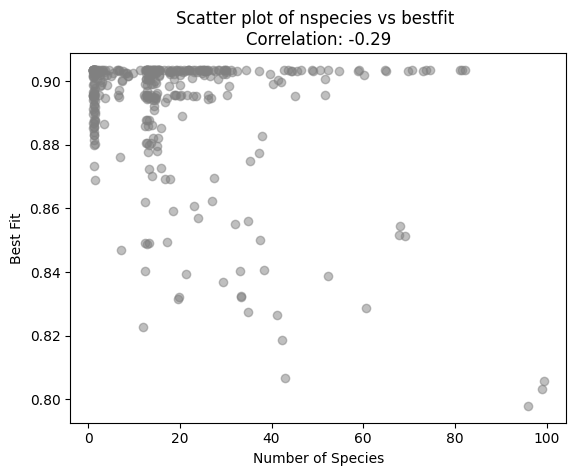

Correlation coefficient: -0.29
P-value: 1.4442724635047018e-08


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Assuming bestfit and nspecies are your data arrays
bestfit = np.array(bestfit)
nspecies = np.array(nspecies)

# Calculate the Pearson correlation coefficient
correlation_coefficient, p_value = pearsonr(nspecies, bestfit)

# Plot the scatter plot
plt.scatter(nspecies, bestfit, color='grey', alpha=0.5)
plt.title(f'Scatter plot of nspecies vs bestfit \nCorrelation: {correlation_coefficient:.2f}')
plt.xlabel('Number of Species')
plt.ylabel('Best Fit')
plt.show()

print(f'Correlation coefficient: {correlation_coefficient:.2f}')
print(f'P-value: {p_value}')

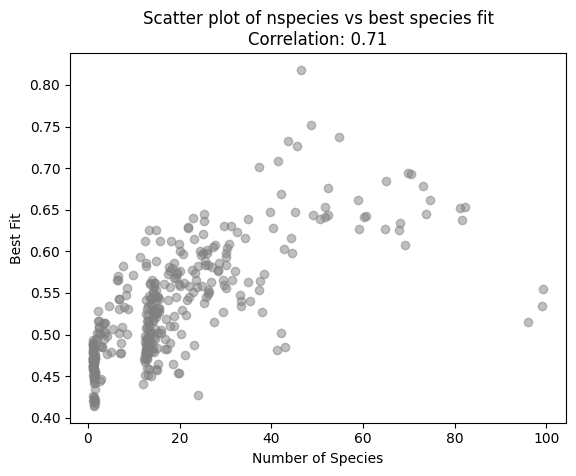

Correlation coefficient: 0.71
P-value: 2.7412345789658867e-56


In [54]:
correlation_coefficient, p_value = pearsonr(nspecies, bestspec)

plt.scatter(nspecies, bestspec, color='grey', alpha=0.5)
plt.title(f'Scatter plot of nspecies vs best species fit\nCorrelation: {correlation_coefficient:.2f}')
plt.xlabel('Number of Species')
plt.ylabel('Best Fit')
plt.show()

print(f'Correlation coefficient: {correlation_coefficient:.2f}')
print(f'P-value: {p_value}')

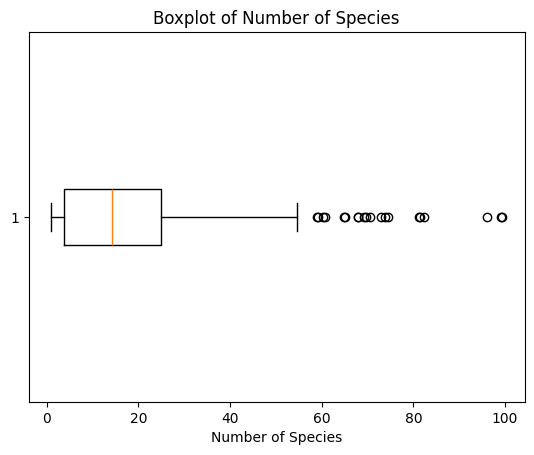

Five-number summary of Number of Species:
Minimum: 1.0
First Quartile (Q1): 3.75
Median: 14.175
Third Quartile (Q3): 24.924999999999997
Maximum: 99.35


In [50]:
plt.boxplot(nspecies, vert=False)
plt.title('Boxplot of Number of Species')
plt.xlabel('Number of Species')
plt.show()

# Calculate the five-number summary
min_val = np.min(nspecies)
q1 = np.percentile(nspecies, 25)
median = np.median(nspecies)
q3 = np.percentile(nspecies, 75)
max_val = np.max(nspecies)

# Print the five-number summary
print("Five-number summary of Number of Species:")
print(f"Minimum: {min_val}")
print(f"First Quartile (Q1): {q1}")
print(f"Median: {median}")
print(f"Third Quartile (Q3): {q3}")
print(f"Maximum: {max_val}")

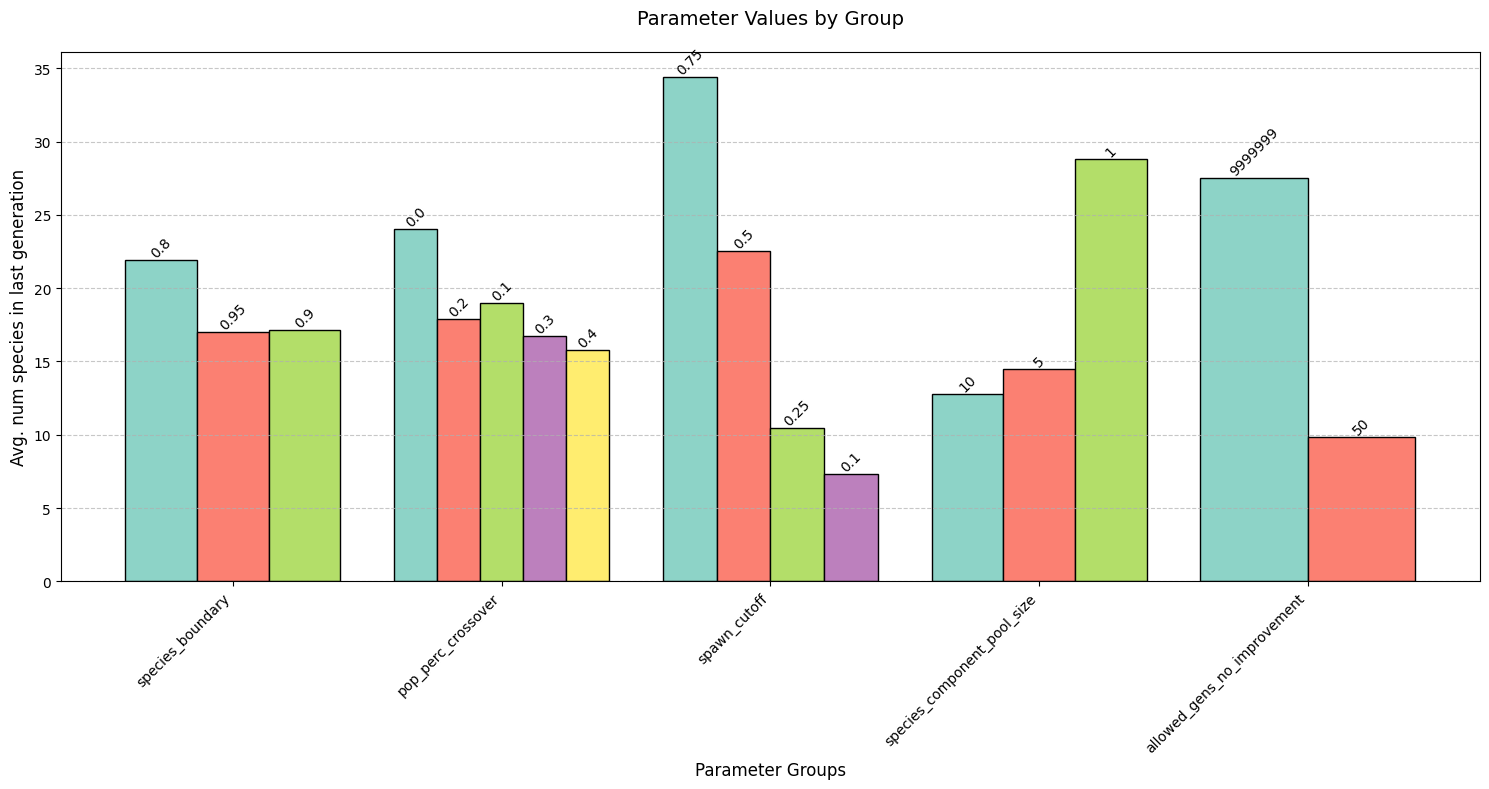

In [70]:
from statistics import mean
from pprint import pprint

pres = {p: {} for p in speciation_predictors}

for params, nspec in zip(matching_params, nspecies):
    for p, val in params.items():
        if val not in pres[p]:
            pres[p][val] = [nspec]
        else:
            pres[p][val].append(nspec)

for p in pres:
    for val in pres[p]:
        l = pres[p][val]
        pres[p][val] = mean(l)

# pprint(pres)
data = pres

plt.figure(figsize=(15, 8))
ax = plt.gca()

# Define color palette for bars within groups
colors = plt.cm.Set3(np.linspace(0, 1, max(len(subdict) for subdict in data.values())))

# Calculate positions for groups and bars
groups = list(data.keys())
group_positions = np.arange(len(groups))
bar_width = 0.8  # Total width for each group
    
# Plot bars for each group
for i, (group_name, group_data) in enumerate(data.items()):
    # Calculate number of bars in this group
    n_bars = len(group_data)
    individual_bar_width = bar_width / n_bars
    
    # Get the keys and values
    keys = list(group_data.keys())
    values = list(group_data.values())
    
    # Calculate positions for individual bars within group
    bar_positions = np.linspace(
        group_positions[i] - bar_width/2 + individual_bar_width/2,
        group_positions[i] + bar_width/2 - individual_bar_width/2,
        n_bars
    )
    
    # Plot bars with different colors and black edges
    bars = plt.bar(bar_positions, values, 
                  width=individual_bar_width,
                  color=colors[:n_bars],
                  edgecolor='black',
                  linewidth=1)
    
    # Add key labels on top of each bar
    for bar, key in zip(bars, keys):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{key}',  # Show key instead of value
                ha='center', va='bottom', rotation=45)

# Customize the plot
plt.title('Parameter Values by Group', pad=20, size=14)
plt.xlabel('Parameter Groups', size=12)
plt.ylabel('Avg. num species in last generation', size=12)

# Set x-axis ticks and labels
plt.xticks(group_positions, groups, rotation=45, ha='right')

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


I assume that the number of species in the last generation is the equilibrium number of species.

seems the parameters with the biggest effect on the number of species in the last generation are the spawn cutoff, component pool size and allowed gens no improvement.

In [85]:
speciation_fitness_results = sa.get_best_setups(speciation_res["final_report"])
full_converge = len(speciation_fitness_results.filter(pl.col("std_fitness")==0))
print("number of setups where every run converged to max fit:\n", full_converge)
speciation_fitness_results.head(105)

number of setups where every run converged to max fit:
 103


setupname,mean_fitness,max_fitness,median_fitness,std_fitness
str,f64,f64,f64,f64
"""setup_187""",0.903509,0.903509,0.903509,0.0
"""setup_322""",0.903509,0.903509,0.903509,0.0
"""setup_308""",0.903509,0.903509,0.903509,0.0
"""setup_205""",0.903509,0.903509,0.903509,0.0
"""setup_95""",0.903509,0.903509,0.903509,0.0
…,…,…,…,…
"""setup_42""",0.903509,0.903509,0.903509,0.0
"""setup_164""",0.903509,0.903509,0.903509,0.0
"""setup_70""",0.903509,0.903509,0.903509,0.0


ok this is kinda crazy... The top 103 setups converged in all 20 runs to the same maximum fitness. That is actually way better than the other selection strategies.